In [189]:
# Use the following to install PyTorch on Windows with Nvidia GPU. Link: https://pytorch.org/get-started/locally/#anaconda-1
#!pip install https://download.pytorch.org/whl/cu90/torch-1.0.1-cp37-cp37m-win_amd64.whl
#!pip install torchvision

# Load required libraries:
import os
import pandas as pd
import numpy as np
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

# Load data:
pcap_flow = pd.read_csv('labeled_test.csv')

# Specify labels data:
labels = pcap_flow.pop('Label')
labels = (labels == 'botnet').astype(float).values

# Select variables:
#pcap_flow = [['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']]
'''
pcap_flow = pcap_flow[['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std','Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max','Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt','Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg','Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
        'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std']]
'''
variables = pcap_flow[['Src Port', 'Dst Port', 'Protocol', 'Fwd Pkt Len Max',
                       'Fwd Pkt Len Std', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
                       'Flow IAT Max', 'Fwd IAT Max', 'Bwd IAT Tot',
                       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Pkts/s',
                       'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'FIN Flag Cnt',
                       'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio',
                       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Init Bwd Win Byts', 'Idle Mean',
                       'Idle Max', 'Idle Min']].apply(pd.to_numeric).values

scaler = MinMaxScaler()
variables = scaler.fit_transform(variables)


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(variables, labels, shuffle=True, random_state=100, test_size=0.3)


In [195]:
class Deep_Neural_Network(nn.Module):
    def __init__(self, D_in, fc1_size=40, fc2_size=20, fc3_size=40, fc4_size=20, fc5_size=40):
        """
        Neural Network model with 1 hidden layer.

        D_in: Dimension of input
        fc1_size, fc2_size, etc.: Dimensions of respective hidden layers
        """
        super(Deep_Neural_Network, self).__init__()
        
        # Input Layer:
        self.fc1 = nn.Linear(D_in, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        #self.bn1 = nn.BatchNorm1d(fc1_size)
        self.relu1 = nn.LeakyReLU()
        
        # 2nd Layer:
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        #self.bn2 = nn.BatchNorm1d(fc2_size)
        self.relu2 = nn.LeakyReLU()
        
        # 3rd Layer:
        self.fc3 = nn.Linear(fc2_size, fc3_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        #self.bn3 = nn.BatchNorm1d(fc3_size)
        self.relu3 = nn.LeakyReLU()
        
        # 4rd Layer:
        self.fc4 = nn.Linear(fc3_size, fc4_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        #self.bn4 = nn.BatchNorm1d(fc4_size)
        self.relu4 = nn.LeakyReLU()
        
        # 5th Layer:
        self.fc5 = nn.Linear(fc4_size, fc5_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        #self.bn5 = nn.BatchNorm1d(fc5_size)
        self.relu5 = nn.LeakyReLU()
        
        # Final Layer:
        self.fc_output = nn.Linear(fc5_size, 1) # 1 because this is binary classification
        self.fc_output_activation = nn.Sigmoid()
        
        # Dropout implemented across all layers except Final Layer:
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        """
        Forward function acceps a Tensor of input data and returns a tensor of output data.
        """
        #out = self.dropout(self.relu1(self.bn1(self.fc1(x))))
        #out = self.dropout(self.relu2(self.bn2(self.fc2(out))))
        #out = self.dropout(self.relu3(self.bn3(self.fc3(out))))
        #out = self.dropout(self.relu4(self.bn4(self.fc4(out))))
        #out = self.dropout(self.relu5(self.bn5(self.fc5(out))))
        out = self.dropout(self.relu1(self.fc1(x)))
        out = self.dropout(self.relu2(self.fc2(out)))
        out = self.dropout(self.relu3(self.fc3(out)))
        out = self.dropout(self.relu4(self.fc4(out)))
        out = self.dropout(self.relu5(self.fc5(out)))
        out = self.fc_output_activation(self.fc_output(out))
        return out

In [191]:
def train_DNN(data, target, batch_size, epochs, learning_rate):
    
    # Check if CUDA is available for GPU usage:
    cuda_checker = torch.cuda.is_available()
    
    # Making dataset iterable:
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(data), torch.tensor(target))
    train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

    # Instantiate Neural Network:
    net = Deep_Neural_Network(D_in=data.shape[1])
    
    # If CUDA is available, run model on GPU:
    if cuda_checker:
        net = net.cuda()
    
    # Switch to train mode:
    net.train()
    
    # Create Adam optimizer (recommended for Deep Neural Networks; betas=(0.9, 0.999) is recommended):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    # Create Binary Cross Entropy loss function:
    criterion = nn.BCELoss()
    #criterion = nn.SmoothL1Loss()
    
    # Create total_losses list for plotting:
    total_losses = []

    # Run the main training loop:
    for epoch in range(epochs):
        
        losses = []

        for batch_i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = Variable(x_batch), Variable(y_batch)

            # If CUDA is available, run data computations on GPU:
            if cuda_checker:
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
            
            # Zeros out all "delta" matrices before a new batch iteration:
            optimizer.zero_grad()

            # Forward propagation:
            net_out = net(x_batch)

            # Compute performance criterion:
            actual = y_batch.float().reshape(-1, 1)
            loss = criterion(net_out, actual)

            # Backward propagation:
            loss.backward()

            # Update weights:
            optimizer.step()
            
            # Append to total losses list:
            losses.append(loss.data.cpu().numpy())

            print('Train Epoch #{} [ {}/{} ({:.0f}%) ] Loss: {:.3f}'.format(
                epoch, batch_i * len(x_batch), len(train_loader.dataset),
                100.0 * batch_i / len(train_loader), loss.data.item()))

        total_losses += losses
        
        # Calculate average loss per batch:
        l = len(total_losses)
        no_remainder = l // batch_size * batch_size
        remainder = l - no_remainder
        total_losses_avg = np.append(np.mean(np.array(total_losses[0:no_remainder]).reshape(-1, batch_size), axis=1), np.mean(np.array(total_losses[-remainder:])))

    return [net, total_losses_avg]

def test_DNN(data, target, model, batch_size):
    
    # Check if CUDA is available for GPU usage:
    cuda_checker = torch.cuda.is_available()
    
    # Switch to evaluate mode:
    model.eval()
    
    # Transform data into desired format with specified batch size:
    test_tensor = torch.utils.data.TensorDataset(torch.Tensor(data), torch.tensor(target))
    test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size)
    
    # Initiate accuracy calculation: 
    test_accuracy = 0.0
    
    # Initiate predictions output of the function:
    predictions_output = []
    
    # Run the main testing loop:
    for batch_i, (x_batch, y_batch) in enumerate(test_loader):
        
        # If CUDA is available, run data computations on GPU:
        if cuda_checker:
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                
        # Predict classes of test set:
        outputs = model(x_batch)

        # Identify whether prediction is 0 or 1 (1 if probability is >= 0.5):
        predictions = [float(value[0]) for value in (outputs >= 0.5).tolist()]
        
        # Format actuals for comparison:
        actual = y_batch.tolist()
        
        # Append to the output predictions:
        predictions_output.extend(predictions)
        
        # Identify accuracy of predictions and append to accuracy calculation:
        test_accuracy += np.sum([int(prediction == y_batch[i]) for i, prediction in enumerate(predictions)])

    # Compute average accuracy and loss over all test values:
    test_accuracy = test_accuracy / float(data.shape[0])
    print("Testing accuracy of the given model is {0}.".format(round(test_accuracy, 3)))
    
    # Format prediction output as pandas Series:
    predictions_output = pd.Series(predictions_output)
    
    return predictions_output

In [196]:
res = train_DNN(data=X_train, target=y_train, batch_size=200, epochs=15, learning_rate=0.001)

Train Epoch #0 [ 0/249311 (0%) ] Loss: 0.896
Train Epoch #0 [ 200/249311 (0%) ] Loss: 0.916
Train Epoch #0 [ 400/249311 (0%) ] Loss: 0.861
Train Epoch #0 [ 600/249311 (0%) ] Loss: 0.849
Train Epoch #0 [ 800/249311 (0%) ] Loss: 0.825
Train Epoch #0 [ 1000/249311 (0%) ] Loss: 0.844
Train Epoch #0 [ 1200/249311 (0%) ] Loss: 0.807
Train Epoch #0 [ 1400/249311 (1%) ] Loss: 0.813
Train Epoch #0 [ 1600/249311 (1%) ] Loss: 0.769
Train Epoch #0 [ 1800/249311 (1%) ] Loss: 0.780
Train Epoch #0 [ 2000/249311 (1%) ] Loss: 0.734
Train Epoch #0 [ 2200/249311 (1%) ] Loss: 0.746
Train Epoch #0 [ 2400/249311 (1%) ] Loss: 0.762
Train Epoch #0 [ 2600/249311 (1%) ] Loss: 0.736
Train Epoch #0 [ 2800/249311 (1%) ] Loss: 0.749
Train Epoch #0 [ 3000/249311 (1%) ] Loss: 0.729
Train Epoch #0 [ 3200/249311 (1%) ] Loss: 0.704
Train Epoch #0 [ 3400/249311 (1%) ] Loss: 0.687
Train Epoch #0 [ 3600/249311 (1%) ] Loss: 0.701
Train Epoch #0 [ 3800/249311 (2%) ] Loss: 0.691
Train Epoch #0 [ 4000/249311 (2%) ] Loss: 0.695

Train Epoch #0 [ 33600/249311 (13%) ] Loss: 0.531
Train Epoch #0 [ 33800/249311 (14%) ] Loss: 0.520
Train Epoch #0 [ 34000/249311 (14%) ] Loss: 0.516
Train Epoch #0 [ 34200/249311 (14%) ] Loss: 0.515
Train Epoch #0 [ 34400/249311 (14%) ] Loss: 0.512
Train Epoch #0 [ 34600/249311 (14%) ] Loss: 0.565
Train Epoch #0 [ 34800/249311 (14%) ] Loss: 0.587
Train Epoch #0 [ 35000/249311 (14%) ] Loss: 0.601
Train Epoch #0 [ 35200/249311 (14%) ] Loss: 0.505
Train Epoch #0 [ 35400/249311 (14%) ] Loss: 0.530
Train Epoch #0 [ 35600/249311 (14%) ] Loss: 0.510
Train Epoch #0 [ 35800/249311 (14%) ] Loss: 0.588
Train Epoch #0 [ 36000/249311 (14%) ] Loss: 0.525
Train Epoch #0 [ 36200/249311 (15%) ] Loss: 0.512
Train Epoch #0 [ 36400/249311 (15%) ] Loss: 0.484
Train Epoch #0 [ 36600/249311 (15%) ] Loss: 0.508
Train Epoch #0 [ 36800/249311 (15%) ] Loss: 0.556
Train Epoch #0 [ 37000/249311 (15%) ] Loss: 0.529
Train Epoch #0 [ 37200/249311 (15%) ] Loss: 0.540
Train Epoch #0 [ 37400/249311 (15%) ] Loss: 0.504


Train Epoch #0 [ 67600/249311 (27%) ] Loss: 0.418
Train Epoch #0 [ 67800/249311 (27%) ] Loss: 0.529
Train Epoch #0 [ 68000/249311 (27%) ] Loss: 0.404
Train Epoch #0 [ 68200/249311 (27%) ] Loss: 0.432
Train Epoch #0 [ 68400/249311 (27%) ] Loss: 0.526
Train Epoch #0 [ 68600/249311 (28%) ] Loss: 0.429
Train Epoch #0 [ 68800/249311 (28%) ] Loss: 0.522
Train Epoch #0 [ 69000/249311 (28%) ] Loss: 0.516
Train Epoch #0 [ 69200/249311 (28%) ] Loss: 0.522
Train Epoch #0 [ 69400/249311 (28%) ] Loss: 0.406
Train Epoch #0 [ 69600/249311 (28%) ] Loss: 0.447
Train Epoch #0 [ 69800/249311 (28%) ] Loss: 0.430
Train Epoch #0 [ 70000/249311 (28%) ] Loss: 0.435
Train Epoch #0 [ 70200/249311 (28%) ] Loss: 0.399
Train Epoch #0 [ 70400/249311 (28%) ] Loss: 0.425
Train Epoch #0 [ 70600/249311 (28%) ] Loss: 0.474
Train Epoch #0 [ 70800/249311 (28%) ] Loss: 0.452
Train Epoch #0 [ 71000/249311 (28%) ] Loss: 0.493
Train Epoch #0 [ 71200/249311 (29%) ] Loss: 0.458
Train Epoch #0 [ 71400/249311 (29%) ] Loss: 0.422


Train Epoch #0 [ 100200/249311 (40%) ] Loss: 0.378
Train Epoch #0 [ 100400/249311 (40%) ] Loss: 0.398
Train Epoch #0 [ 100600/249311 (40%) ] Loss: 0.502
Train Epoch #0 [ 100800/249311 (40%) ] Loss: 0.368
Train Epoch #0 [ 101000/249311 (40%) ] Loss: 0.426
Train Epoch #0 [ 101200/249311 (41%) ] Loss: 0.538
Train Epoch #0 [ 101400/249311 (41%) ] Loss: 0.429
Train Epoch #0 [ 101600/249311 (41%) ] Loss: 0.435
Train Epoch #0 [ 101800/249311 (41%) ] Loss: 0.434
Train Epoch #0 [ 102000/249311 (41%) ] Loss: 0.385
Train Epoch #0 [ 102200/249311 (41%) ] Loss: 0.378
Train Epoch #0 [ 102400/249311 (41%) ] Loss: 0.378
Train Epoch #0 [ 102600/249311 (41%) ] Loss: 0.397
Train Epoch #0 [ 102800/249311 (41%) ] Loss: 0.394
Train Epoch #0 [ 103000/249311 (41%) ] Loss: 0.321
Train Epoch #0 [ 103200/249311 (41%) ] Loss: 0.351
Train Epoch #0 [ 103400/249311 (41%) ] Loss: 0.438
Train Epoch #0 [ 103600/249311 (42%) ] Loss: 0.410
Train Epoch #0 [ 103800/249311 (42%) ] Loss: 0.449
Train Epoch #0 [ 104000/249311 

Train Epoch #0 [ 133000/249311 (53%) ] Loss: 0.359
Train Epoch #0 [ 133200/249311 (53%) ] Loss: 0.382
Train Epoch #0 [ 133400/249311 (53%) ] Loss: 0.492
Train Epoch #0 [ 133600/249311 (54%) ] Loss: 0.414
Train Epoch #0 [ 133800/249311 (54%) ] Loss: 0.360
Train Epoch #0 [ 134000/249311 (54%) ] Loss: 0.325
Train Epoch #0 [ 134200/249311 (54%) ] Loss: 0.354
Train Epoch #0 [ 134400/249311 (54%) ] Loss: 0.344
Train Epoch #0 [ 134600/249311 (54%) ] Loss: 0.423
Train Epoch #0 [ 134800/249311 (54%) ] Loss: 0.494
Train Epoch #0 [ 135000/249311 (54%) ] Loss: 0.266
Train Epoch #0 [ 135200/249311 (54%) ] Loss: 0.372
Train Epoch #0 [ 135400/249311 (54%) ] Loss: 0.469
Train Epoch #0 [ 135600/249311 (54%) ] Loss: 0.369
Train Epoch #0 [ 135800/249311 (54%) ] Loss: 0.374
Train Epoch #0 [ 136000/249311 (55%) ] Loss: 0.303
Train Epoch #0 [ 136200/249311 (55%) ] Loss: 0.354
Train Epoch #0 [ 136400/249311 (55%) ] Loss: 0.391
Train Epoch #0 [ 136600/249311 (55%) ] Loss: 0.433
Train Epoch #0 [ 136800/249311 

Train Epoch #0 [ 166200/249311 (67%) ] Loss: 0.392
Train Epoch #0 [ 166400/249311 (67%) ] Loss: 0.396
Train Epoch #0 [ 166600/249311 (67%) ] Loss: 0.312
Train Epoch #0 [ 166800/249311 (67%) ] Loss: 0.399
Train Epoch #0 [ 167000/249311 (67%) ] Loss: 0.415
Train Epoch #0 [ 167200/249311 (67%) ] Loss: 0.353
Train Epoch #0 [ 167400/249311 (67%) ] Loss: 0.301
Train Epoch #0 [ 167600/249311 (67%) ] Loss: 0.372
Train Epoch #0 [ 167800/249311 (67%) ] Loss: 0.399
Train Epoch #0 [ 168000/249311 (67%) ] Loss: 0.429
Train Epoch #0 [ 168200/249311 (67%) ] Loss: 0.359
Train Epoch #0 [ 168400/249311 (68%) ] Loss: 0.396
Train Epoch #0 [ 168600/249311 (68%) ] Loss: 0.524
Train Epoch #0 [ 168800/249311 (68%) ] Loss: 0.343
Train Epoch #0 [ 169000/249311 (68%) ] Loss: 0.336
Train Epoch #0 [ 169200/249311 (68%) ] Loss: 0.372
Train Epoch #0 [ 169400/249311 (68%) ] Loss: 0.369
Train Epoch #0 [ 169600/249311 (68%) ] Loss: 0.355
Train Epoch #0 [ 169800/249311 (68%) ] Loss: 0.379
Train Epoch #0 [ 170000/249311 

Train Epoch #0 [ 200600/249311 (80%) ] Loss: 0.402
Train Epoch #0 [ 200800/249311 (81%) ] Loss: 0.277
Train Epoch #0 [ 201000/249311 (81%) ] Loss: 0.344
Train Epoch #0 [ 201200/249311 (81%) ] Loss: 0.354
Train Epoch #0 [ 201400/249311 (81%) ] Loss: 0.305
Train Epoch #0 [ 201600/249311 (81%) ] Loss: 0.275
Train Epoch #0 [ 201800/249311 (81%) ] Loss: 0.349
Train Epoch #0 [ 202000/249311 (81%) ] Loss: 0.329
Train Epoch #0 [ 202200/249311 (81%) ] Loss: 0.271
Train Epoch #0 [ 202400/249311 (81%) ] Loss: 0.300
Train Epoch #0 [ 202600/249311 (81%) ] Loss: 0.393
Train Epoch #0 [ 202800/249311 (81%) ] Loss: 0.288
Train Epoch #0 [ 203000/249311 (81%) ] Loss: 0.382
Train Epoch #0 [ 203200/249311 (81%) ] Loss: 0.253
Train Epoch #0 [ 203400/249311 (82%) ] Loss: 0.386
Train Epoch #0 [ 203600/249311 (82%) ] Loss: 0.338
Train Epoch #0 [ 203800/249311 (82%) ] Loss: 0.329
Train Epoch #0 [ 204000/249311 (82%) ] Loss: 0.348
Train Epoch #0 [ 204200/249311 (82%) ] Loss: 0.312
Train Epoch #0 [ 204400/249311 

Train Epoch #0 [ 232600/249311 (93%) ] Loss: 0.334
Train Epoch #0 [ 232800/249311 (93%) ] Loss: 0.346
Train Epoch #0 [ 233000/249311 (93%) ] Loss: 0.481
Train Epoch #0 [ 233200/249311 (94%) ] Loss: 0.294
Train Epoch #0 [ 233400/249311 (94%) ] Loss: 0.349
Train Epoch #0 [ 233600/249311 (94%) ] Loss: 0.252
Train Epoch #0 [ 233800/249311 (94%) ] Loss: 0.295
Train Epoch #0 [ 234000/249311 (94%) ] Loss: 0.382
Train Epoch #0 [ 234200/249311 (94%) ] Loss: 0.271
Train Epoch #0 [ 234400/249311 (94%) ] Loss: 0.327
Train Epoch #0 [ 234600/249311 (94%) ] Loss: 0.307
Train Epoch #0 [ 234800/249311 (94%) ] Loss: 0.455
Train Epoch #0 [ 235000/249311 (94%) ] Loss: 0.328
Train Epoch #0 [ 235200/249311 (94%) ] Loss: 0.388
Train Epoch #0 [ 235400/249311 (94%) ] Loss: 0.304
Train Epoch #0 [ 235600/249311 (94%) ] Loss: 0.283
Train Epoch #0 [ 235800/249311 (95%) ] Loss: 0.320
Train Epoch #0 [ 236000/249311 (95%) ] Loss: 0.307
Train Epoch #0 [ 236200/249311 (95%) ] Loss: 0.285
Train Epoch #0 [ 236400/249311 

Train Epoch #1 [ 16200/249311 (6%) ] Loss: 0.298
Train Epoch #1 [ 16400/249311 (7%) ] Loss: 0.330
Train Epoch #1 [ 16600/249311 (7%) ] Loss: 0.336
Train Epoch #1 [ 16800/249311 (7%) ] Loss: 0.357
Train Epoch #1 [ 17000/249311 (7%) ] Loss: 0.320
Train Epoch #1 [ 17200/249311 (7%) ] Loss: 0.344
Train Epoch #1 [ 17400/249311 (7%) ] Loss: 0.399
Train Epoch #1 [ 17600/249311 (7%) ] Loss: 0.417
Train Epoch #1 [ 17800/249311 (7%) ] Loss: 0.317
Train Epoch #1 [ 18000/249311 (7%) ] Loss: 0.268
Train Epoch #1 [ 18200/249311 (7%) ] Loss: 0.355
Train Epoch #1 [ 18400/249311 (7%) ] Loss: 0.324
Train Epoch #1 [ 18600/249311 (7%) ] Loss: 0.375
Train Epoch #1 [ 18800/249311 (8%) ] Loss: 0.360
Train Epoch #1 [ 19000/249311 (8%) ] Loss: 0.340
Train Epoch #1 [ 19200/249311 (8%) ] Loss: 0.294
Train Epoch #1 [ 19400/249311 (8%) ] Loss: 0.334
Train Epoch #1 [ 19600/249311 (8%) ] Loss: 0.329
Train Epoch #1 [ 19800/249311 (8%) ] Loss: 0.305
Train Epoch #1 [ 20000/249311 (8%) ] Loss: 0.268
Train Epoch #1 [ 202

Train Epoch #1 [ 50000/249311 (20%) ] Loss: 0.333
Train Epoch #1 [ 50200/249311 (20%) ] Loss: 0.384
Train Epoch #1 [ 50400/249311 (20%) ] Loss: 0.376
Train Epoch #1 [ 50600/249311 (20%) ] Loss: 0.305
Train Epoch #1 [ 50800/249311 (20%) ] Loss: 0.335
Train Epoch #1 [ 51000/249311 (20%) ] Loss: 0.328
Train Epoch #1 [ 51200/249311 (21%) ] Loss: 0.310
Train Epoch #1 [ 51400/249311 (21%) ] Loss: 0.325
Train Epoch #1 [ 51600/249311 (21%) ] Loss: 0.345
Train Epoch #1 [ 51800/249311 (21%) ] Loss: 0.303
Train Epoch #1 [ 52000/249311 (21%) ] Loss: 0.335
Train Epoch #1 [ 52200/249311 (21%) ] Loss: 0.326
Train Epoch #1 [ 52400/249311 (21%) ] Loss: 0.418
Train Epoch #1 [ 52600/249311 (21%) ] Loss: 0.392
Train Epoch #1 [ 52800/249311 (21%) ] Loss: 0.363
Train Epoch #1 [ 53000/249311 (21%) ] Loss: 0.329
Train Epoch #1 [ 53200/249311 (21%) ] Loss: 0.316
Train Epoch #1 [ 53400/249311 (21%) ] Loss: 0.353
Train Epoch #1 [ 53600/249311 (21%) ] Loss: 0.331
Train Epoch #1 [ 53800/249311 (22%) ] Loss: 0.341


Train Epoch #1 [ 84200/249311 (34%) ] Loss: 0.258
Train Epoch #1 [ 84400/249311 (34%) ] Loss: 0.399
Train Epoch #1 [ 84600/249311 (34%) ] Loss: 0.385
Train Epoch #1 [ 84800/249311 (34%) ] Loss: 0.273
Train Epoch #1 [ 85000/249311 (34%) ] Loss: 0.305
Train Epoch #1 [ 85200/249311 (34%) ] Loss: 0.270
Train Epoch #1 [ 85400/249311 (34%) ] Loss: 0.300
Train Epoch #1 [ 85600/249311 (34%) ] Loss: 0.325
Train Epoch #1 [ 85800/249311 (34%) ] Loss: 0.316
Train Epoch #1 [ 86000/249311 (34%) ] Loss: 0.223
Train Epoch #1 [ 86200/249311 (35%) ] Loss: 0.221
Train Epoch #1 [ 86400/249311 (35%) ] Loss: 0.384
Train Epoch #1 [ 86600/249311 (35%) ] Loss: 0.409
Train Epoch #1 [ 86800/249311 (35%) ] Loss: 0.313
Train Epoch #1 [ 87000/249311 (35%) ] Loss: 0.253
Train Epoch #1 [ 87200/249311 (35%) ] Loss: 0.268
Train Epoch #1 [ 87400/249311 (35%) ] Loss: 0.251
Train Epoch #1 [ 87600/249311 (35%) ] Loss: 0.324
Train Epoch #1 [ 87800/249311 (35%) ] Loss: 0.263
Train Epoch #1 [ 88000/249311 (35%) ] Loss: 0.319


Train Epoch #1 [ 116800/249311 (47%) ] Loss: 0.341
Train Epoch #1 [ 117000/249311 (47%) ] Loss: 0.367
Train Epoch #1 [ 117200/249311 (47%) ] Loss: 0.364
Train Epoch #1 [ 117400/249311 (47%) ] Loss: 0.299
Train Epoch #1 [ 117600/249311 (47%) ] Loss: 0.267
Train Epoch #1 [ 117800/249311 (47%) ] Loss: 0.309
Train Epoch #1 [ 118000/249311 (47%) ] Loss: 0.270
Train Epoch #1 [ 118200/249311 (47%) ] Loss: 0.294
Train Epoch #1 [ 118400/249311 (47%) ] Loss: 0.226
Train Epoch #1 [ 118600/249311 (48%) ] Loss: 0.244
Train Epoch #1 [ 118800/249311 (48%) ] Loss: 0.262
Train Epoch #1 [ 119000/249311 (48%) ] Loss: 0.314
Train Epoch #1 [ 119200/249311 (48%) ] Loss: 0.304
Train Epoch #1 [ 119400/249311 (48%) ] Loss: 0.363
Train Epoch #1 [ 119600/249311 (48%) ] Loss: 0.349
Train Epoch #1 [ 119800/249311 (48%) ] Loss: 0.334
Train Epoch #1 [ 120000/249311 (48%) ] Loss: 0.325
Train Epoch #1 [ 120200/249311 (48%) ] Loss: 0.275
Train Epoch #1 [ 120400/249311 (48%) ] Loss: 0.370
Train Epoch #1 [ 120600/249311 

Train Epoch #1 [ 150200/249311 (60%) ] Loss: 0.253
Train Epoch #1 [ 150400/249311 (60%) ] Loss: 0.295
Train Epoch #1 [ 150600/249311 (60%) ] Loss: 0.241
Train Epoch #1 [ 150800/249311 (60%) ] Loss: 0.291
Train Epoch #1 [ 151000/249311 (61%) ] Loss: 0.271
Train Epoch #1 [ 151200/249311 (61%) ] Loss: 0.337
Train Epoch #1 [ 151400/249311 (61%) ] Loss: 0.314
Train Epoch #1 [ 151600/249311 (61%) ] Loss: 0.347
Train Epoch #1 [ 151800/249311 (61%) ] Loss: 0.298
Train Epoch #1 [ 152000/249311 (61%) ] Loss: 0.273
Train Epoch #1 [ 152200/249311 (61%) ] Loss: 0.263
Train Epoch #1 [ 152400/249311 (61%) ] Loss: 0.274
Train Epoch #1 [ 152600/249311 (61%) ] Loss: 0.367
Train Epoch #1 [ 152800/249311 (61%) ] Loss: 0.337
Train Epoch #1 [ 153000/249311 (61%) ] Loss: 0.332
Train Epoch #1 [ 153200/249311 (61%) ] Loss: 0.300
Train Epoch #1 [ 153400/249311 (62%) ] Loss: 0.299
Train Epoch #1 [ 153600/249311 (62%) ] Loss: 0.289
Train Epoch #1 [ 153800/249311 (62%) ] Loss: 0.346
Train Epoch #1 [ 154000/249311 

Train Epoch #1 [ 182400/249311 (73%) ] Loss: 0.231
Train Epoch #1 [ 182600/249311 (73%) ] Loss: 0.301
Train Epoch #1 [ 182800/249311 (73%) ] Loss: 0.338
Train Epoch #1 [ 183000/249311 (73%) ] Loss: 0.299
Train Epoch #1 [ 183200/249311 (73%) ] Loss: 0.367
Train Epoch #1 [ 183400/249311 (74%) ] Loss: 0.286
Train Epoch #1 [ 183600/249311 (74%) ] Loss: 0.361
Train Epoch #1 [ 183800/249311 (74%) ] Loss: 0.294
Train Epoch #1 [ 184000/249311 (74%) ] Loss: 0.363
Train Epoch #1 [ 184200/249311 (74%) ] Loss: 0.245
Train Epoch #1 [ 184400/249311 (74%) ] Loss: 0.298
Train Epoch #1 [ 184600/249311 (74%) ] Loss: 0.276
Train Epoch #1 [ 184800/249311 (74%) ] Loss: 0.335
Train Epoch #1 [ 185000/249311 (74%) ] Loss: 0.309
Train Epoch #1 [ 185200/249311 (74%) ] Loss: 0.274
Train Epoch #1 [ 185400/249311 (74%) ] Loss: 0.331
Train Epoch #1 [ 185600/249311 (74%) ] Loss: 0.266
Train Epoch #1 [ 185800/249311 (74%) ] Loss: 0.329
Train Epoch #1 [ 186000/249311 (75%) ] Loss: 0.277
Train Epoch #1 [ 186200/249311 

Train Epoch #1 [ 216200/249311 (87%) ] Loss: 0.215
Train Epoch #1 [ 216400/249311 (87%) ] Loss: 0.258
Train Epoch #1 [ 216600/249311 (87%) ] Loss: 0.339
Train Epoch #1 [ 216800/249311 (87%) ] Loss: 0.308
Train Epoch #1 [ 217000/249311 (87%) ] Loss: 0.246
Train Epoch #1 [ 217200/249311 (87%) ] Loss: 0.325
Train Epoch #1 [ 217400/249311 (87%) ] Loss: 0.357
Train Epoch #1 [ 217600/249311 (87%) ] Loss: 0.370
Train Epoch #1 [ 217800/249311 (87%) ] Loss: 0.257
Train Epoch #1 [ 218000/249311 (87%) ] Loss: 0.259
Train Epoch #1 [ 218200/249311 (87%) ] Loss: 0.206
Train Epoch #1 [ 218400/249311 (88%) ] Loss: 0.243
Train Epoch #1 [ 218600/249311 (88%) ] Loss: 0.308
Train Epoch #1 [ 218800/249311 (88%) ] Loss: 0.257
Train Epoch #1 [ 219000/249311 (88%) ] Loss: 0.252
Train Epoch #1 [ 219200/249311 (88%) ] Loss: 0.315
Train Epoch #1 [ 219400/249311 (88%) ] Loss: 0.366
Train Epoch #1 [ 219600/249311 (88%) ] Loss: 0.350
Train Epoch #1 [ 219800/249311 (88%) ] Loss: 0.254
Train Epoch #1 [ 220000/249311 

Train Epoch #2 [ 600/249311 (0%) ] Loss: 0.189
Train Epoch #2 [ 800/249311 (0%) ] Loss: 0.330
Train Epoch #2 [ 1000/249311 (0%) ] Loss: 0.219
Train Epoch #2 [ 1200/249311 (0%) ] Loss: 0.291
Train Epoch #2 [ 1400/249311 (1%) ] Loss: 0.260
Train Epoch #2 [ 1600/249311 (1%) ] Loss: 0.334
Train Epoch #2 [ 1800/249311 (1%) ] Loss: 0.228
Train Epoch #2 [ 2000/249311 (1%) ] Loss: 0.294
Train Epoch #2 [ 2200/249311 (1%) ] Loss: 0.418
Train Epoch #2 [ 2400/249311 (1%) ] Loss: 0.328
Train Epoch #2 [ 2600/249311 (1%) ] Loss: 0.322
Train Epoch #2 [ 2800/249311 (1%) ] Loss: 0.240
Train Epoch #2 [ 3000/249311 (1%) ] Loss: 0.273
Train Epoch #2 [ 3200/249311 (1%) ] Loss: 0.394
Train Epoch #2 [ 3400/249311 (1%) ] Loss: 0.310
Train Epoch #2 [ 3600/249311 (1%) ] Loss: 0.345
Train Epoch #2 [ 3800/249311 (2%) ] Loss: 0.281
Train Epoch #2 [ 4000/249311 (2%) ] Loss: 0.229
Train Epoch #2 [ 4200/249311 (2%) ] Loss: 0.309
Train Epoch #2 [ 4400/249311 (2%) ] Loss: 0.274
Train Epoch #2 [ 4600/249311 (2%) ] Loss: 

Train Epoch #2 [ 35800/249311 (14%) ] Loss: 0.335
Train Epoch #2 [ 36000/249311 (14%) ] Loss: 0.308
Train Epoch #2 [ 36200/249311 (15%) ] Loss: 0.296
Train Epoch #2 [ 36400/249311 (15%) ] Loss: 0.326
Train Epoch #2 [ 36600/249311 (15%) ] Loss: 0.311
Train Epoch #2 [ 36800/249311 (15%) ] Loss: 0.215
Train Epoch #2 [ 37000/249311 (15%) ] Loss: 0.324
Train Epoch #2 [ 37200/249311 (15%) ] Loss: 0.303
Train Epoch #2 [ 37400/249311 (15%) ] Loss: 0.294
Train Epoch #2 [ 37600/249311 (15%) ] Loss: 0.304
Train Epoch #2 [ 37800/249311 (15%) ] Loss: 0.287
Train Epoch #2 [ 38000/249311 (15%) ] Loss: 0.289
Train Epoch #2 [ 38200/249311 (15%) ] Loss: 0.233
Train Epoch #2 [ 38400/249311 (15%) ] Loss: 0.299
Train Epoch #2 [ 38600/249311 (15%) ] Loss: 0.290
Train Epoch #2 [ 38800/249311 (16%) ] Loss: 0.287
Train Epoch #2 [ 39000/249311 (16%) ] Loss: 0.205
Train Epoch #2 [ 39200/249311 (16%) ] Loss: 0.301
Train Epoch #2 [ 39400/249311 (16%) ] Loss: 0.226
Train Epoch #2 [ 39600/249311 (16%) ] Loss: 0.294


Train Epoch #2 [ 70600/249311 (28%) ] Loss: 0.253
Train Epoch #2 [ 70800/249311 (28%) ] Loss: 0.324
Train Epoch #2 [ 71000/249311 (28%) ] Loss: 0.258
Train Epoch #2 [ 71200/249311 (29%) ] Loss: 0.294
Train Epoch #2 [ 71400/249311 (29%) ] Loss: 0.276
Train Epoch #2 [ 71600/249311 (29%) ] Loss: 0.342
Train Epoch #2 [ 71800/249311 (29%) ] Loss: 0.272
Train Epoch #2 [ 72000/249311 (29%) ] Loss: 0.309
Train Epoch #2 [ 72200/249311 (29%) ] Loss: 0.329
Train Epoch #2 [ 72400/249311 (29%) ] Loss: 0.277
Train Epoch #2 [ 72600/249311 (29%) ] Loss: 0.349
Train Epoch #2 [ 72800/249311 (29%) ] Loss: 0.343
Train Epoch #2 [ 73000/249311 (29%) ] Loss: 0.312
Train Epoch #2 [ 73200/249311 (29%) ] Loss: 0.291
Train Epoch #2 [ 73400/249311 (29%) ] Loss: 0.391
Train Epoch #2 [ 73600/249311 (30%) ] Loss: 0.244
Train Epoch #2 [ 73800/249311 (30%) ] Loss: 0.335
Train Epoch #2 [ 74000/249311 (30%) ] Loss: 0.363
Train Epoch #2 [ 74200/249311 (30%) ] Loss: 0.212
Train Epoch #2 [ 74400/249311 (30%) ] Loss: 0.326


Train Epoch #2 [ 105000/249311 (42%) ] Loss: 0.345
Train Epoch #2 [ 105200/249311 (42%) ] Loss: 0.324
Train Epoch #2 [ 105400/249311 (42%) ] Loss: 0.388
Train Epoch #2 [ 105600/249311 (42%) ] Loss: 0.302
Train Epoch #2 [ 105800/249311 (42%) ] Loss: 0.284
Train Epoch #2 [ 106000/249311 (43%) ] Loss: 0.315
Train Epoch #2 [ 106200/249311 (43%) ] Loss: 0.301
Train Epoch #2 [ 106400/249311 (43%) ] Loss: 0.301
Train Epoch #2 [ 106600/249311 (43%) ] Loss: 0.348
Train Epoch #2 [ 106800/249311 (43%) ] Loss: 0.356
Train Epoch #2 [ 107000/249311 (43%) ] Loss: 0.265
Train Epoch #2 [ 107200/249311 (43%) ] Loss: 0.288
Train Epoch #2 [ 107400/249311 (43%) ] Loss: 0.259
Train Epoch #2 [ 107600/249311 (43%) ] Loss: 0.295
Train Epoch #2 [ 107800/249311 (43%) ] Loss: 0.243
Train Epoch #2 [ 108000/249311 (43%) ] Loss: 0.258
Train Epoch #2 [ 108200/249311 (43%) ] Loss: 0.315
Train Epoch #2 [ 108400/249311 (43%) ] Loss: 0.289
Train Epoch #2 [ 108600/249311 (44%) ] Loss: 0.296
Train Epoch #2 [ 108800/249311 

Train Epoch #2 [ 138200/249311 (55%) ] Loss: 0.299
Train Epoch #2 [ 138400/249311 (55%) ] Loss: 0.323
Train Epoch #2 [ 138600/249311 (56%) ] Loss: 0.261
Train Epoch #2 [ 138800/249311 (56%) ] Loss: 0.322
Train Epoch #2 [ 139000/249311 (56%) ] Loss: 0.279
Train Epoch #2 [ 139200/249311 (56%) ] Loss: 0.258
Train Epoch #2 [ 139400/249311 (56%) ] Loss: 0.224
Train Epoch #2 [ 139600/249311 (56%) ] Loss: 0.340
Train Epoch #2 [ 139800/249311 (56%) ] Loss: 0.287
Train Epoch #2 [ 140000/249311 (56%) ] Loss: 0.338
Train Epoch #2 [ 140200/249311 (56%) ] Loss: 0.291
Train Epoch #2 [ 140400/249311 (56%) ] Loss: 0.307
Train Epoch #2 [ 140600/249311 (56%) ] Loss: 0.358
Train Epoch #2 [ 140800/249311 (56%) ] Loss: 0.246
Train Epoch #2 [ 141000/249311 (57%) ] Loss: 0.273
Train Epoch #2 [ 141200/249311 (57%) ] Loss: 0.258
Train Epoch #2 [ 141400/249311 (57%) ] Loss: 0.214
Train Epoch #2 [ 141600/249311 (57%) ] Loss: 0.246
Train Epoch #2 [ 141800/249311 (57%) ] Loss: 0.320
Train Epoch #2 [ 142000/249311 

Train Epoch #2 [ 171400/249311 (69%) ] Loss: 0.264
Train Epoch #2 [ 171600/249311 (69%) ] Loss: 0.327
Train Epoch #2 [ 171800/249311 (69%) ] Loss: 0.312
Train Epoch #2 [ 172000/249311 (69%) ] Loss: 0.299
Train Epoch #2 [ 172200/249311 (69%) ] Loss: 0.215
Train Epoch #2 [ 172400/249311 (69%) ] Loss: 0.312
Train Epoch #2 [ 172600/249311 (69%) ] Loss: 0.309
Train Epoch #2 [ 172800/249311 (69%) ] Loss: 0.329
Train Epoch #2 [ 173000/249311 (69%) ] Loss: 0.280
Train Epoch #2 [ 173200/249311 (69%) ] Loss: 0.388
Train Epoch #2 [ 173400/249311 (70%) ] Loss: 0.282
Train Epoch #2 [ 173600/249311 (70%) ] Loss: 0.249
Train Epoch #2 [ 173800/249311 (70%) ] Loss: 0.358
Train Epoch #2 [ 174000/249311 (70%) ] Loss: 0.216
Train Epoch #2 [ 174200/249311 (70%) ] Loss: 0.311
Train Epoch #2 [ 174400/249311 (70%) ] Loss: 0.195
Train Epoch #2 [ 174600/249311 (70%) ] Loss: 0.272
Train Epoch #2 [ 174800/249311 (70%) ] Loss: 0.291
Train Epoch #2 [ 175000/249311 (70%) ] Loss: 0.319
Train Epoch #2 [ 175200/249311 

Train Epoch #2 [ 203600/249311 (82%) ] Loss: 0.215
Train Epoch #2 [ 203800/249311 (82%) ] Loss: 0.275
Train Epoch #2 [ 204000/249311 (82%) ] Loss: 0.342
Train Epoch #2 [ 204200/249311 (82%) ] Loss: 0.308
Train Epoch #2 [ 204400/249311 (82%) ] Loss: 0.243
Train Epoch #2 [ 204600/249311 (82%) ] Loss: 0.234
Train Epoch #2 [ 204800/249311 (82%) ] Loss: 0.304
Train Epoch #2 [ 205000/249311 (82%) ] Loss: 0.346
Train Epoch #2 [ 205200/249311 (82%) ] Loss: 0.245
Train Epoch #2 [ 205400/249311 (82%) ] Loss: 0.186
Train Epoch #2 [ 205600/249311 (82%) ] Loss: 0.260
Train Epoch #2 [ 205800/249311 (83%) ] Loss: 0.278
Train Epoch #2 [ 206000/249311 (83%) ] Loss: 0.258
Train Epoch #2 [ 206200/249311 (83%) ] Loss: 0.234
Train Epoch #2 [ 206400/249311 (83%) ] Loss: 0.303
Train Epoch #2 [ 206600/249311 (83%) ] Loss: 0.284
Train Epoch #2 [ 206800/249311 (83%) ] Loss: 0.315
Train Epoch #2 [ 207000/249311 (83%) ] Loss: 0.263
Train Epoch #2 [ 207200/249311 (83%) ] Loss: 0.225
Train Epoch #2 [ 207400/249311 

Train Epoch #2 [ 236000/249311 (95%) ] Loss: 0.299
Train Epoch #2 [ 236200/249311 (95%) ] Loss: 0.305
Train Epoch #2 [ 236400/249311 (95%) ] Loss: 0.275
Train Epoch #2 [ 236600/249311 (95%) ] Loss: 0.253
Train Epoch #2 [ 236800/249311 (95%) ] Loss: 0.308
Train Epoch #2 [ 237000/249311 (95%) ] Loss: 0.280
Train Epoch #2 [ 237200/249311 (95%) ] Loss: 0.316
Train Epoch #2 [ 237400/249311 (95%) ] Loss: 0.311
Train Epoch #2 [ 237600/249311 (95%) ] Loss: 0.255
Train Epoch #2 [ 237800/249311 (95%) ] Loss: 0.248
Train Epoch #2 [ 238000/249311 (95%) ] Loss: 0.311
Train Epoch #2 [ 238200/249311 (96%) ] Loss: 0.279
Train Epoch #2 [ 238400/249311 (96%) ] Loss: 0.285
Train Epoch #2 [ 238600/249311 (96%) ] Loss: 0.242
Train Epoch #2 [ 238800/249311 (96%) ] Loss: 0.253
Train Epoch #2 [ 239000/249311 (96%) ] Loss: 0.318
Train Epoch #2 [ 239200/249311 (96%) ] Loss: 0.384
Train Epoch #2 [ 239400/249311 (96%) ] Loss: 0.264
Train Epoch #2 [ 239600/249311 (96%) ] Loss: 0.271
Train Epoch #2 [ 239800/249311 

Train Epoch #3 [ 20600/249311 (8%) ] Loss: 0.246
Train Epoch #3 [ 20800/249311 (8%) ] Loss: 0.253
Train Epoch #3 [ 21000/249311 (8%) ] Loss: 0.312
Train Epoch #3 [ 21200/249311 (9%) ] Loss: 0.217
Train Epoch #3 [ 21400/249311 (9%) ] Loss: 0.255
Train Epoch #3 [ 21600/249311 (9%) ] Loss: 0.267
Train Epoch #3 [ 21800/249311 (9%) ] Loss: 0.229
Train Epoch #3 [ 22000/249311 (9%) ] Loss: 0.236
Train Epoch #3 [ 22200/249311 (9%) ] Loss: 0.268
Train Epoch #3 [ 22400/249311 (9%) ] Loss: 0.287
Train Epoch #3 [ 22600/249311 (9%) ] Loss: 0.178
Train Epoch #3 [ 22800/249311 (9%) ] Loss: 0.246
Train Epoch #3 [ 23000/249311 (9%) ] Loss: 0.358
Train Epoch #3 [ 23200/249311 (9%) ] Loss: 0.281
Train Epoch #3 [ 23400/249311 (9%) ] Loss: 0.353
Train Epoch #3 [ 23600/249311 (9%) ] Loss: 0.220
Train Epoch #3 [ 23800/249311 (10%) ] Loss: 0.236
Train Epoch #3 [ 24000/249311 (10%) ] Loss: 0.350
Train Epoch #3 [ 24200/249311 (10%) ] Loss: 0.284
Train Epoch #3 [ 24400/249311 (10%) ] Loss: 0.269
Train Epoch #3 [

Train Epoch #3 [ 54400/249311 (22%) ] Loss: 0.195
Train Epoch #3 [ 54600/249311 (22%) ] Loss: 0.259
Train Epoch #3 [ 54800/249311 (22%) ] Loss: 0.264
Train Epoch #3 [ 55000/249311 (22%) ] Loss: 0.332
Train Epoch #3 [ 55200/249311 (22%) ] Loss: 0.285
Train Epoch #3 [ 55400/249311 (22%) ] Loss: 0.165
Train Epoch #3 [ 55600/249311 (22%) ] Loss: 0.199
Train Epoch #3 [ 55800/249311 (22%) ] Loss: 0.250
Train Epoch #3 [ 56000/249311 (22%) ] Loss: 0.318
Train Epoch #3 [ 56200/249311 (23%) ] Loss: 0.277
Train Epoch #3 [ 56400/249311 (23%) ] Loss: 0.254
Train Epoch #3 [ 56600/249311 (23%) ] Loss: 0.222
Train Epoch #3 [ 56800/249311 (23%) ] Loss: 0.312
Train Epoch #3 [ 57000/249311 (23%) ] Loss: 0.204
Train Epoch #3 [ 57200/249311 (23%) ] Loss: 0.275
Train Epoch #3 [ 57400/249311 (23%) ] Loss: 0.383
Train Epoch #3 [ 57600/249311 (23%) ] Loss: 0.311
Train Epoch #3 [ 57800/249311 (23%) ] Loss: 0.302
Train Epoch #3 [ 58000/249311 (23%) ] Loss: 0.216
Train Epoch #3 [ 58200/249311 (23%) ] Loss: 0.337


Train Epoch #3 [ 87800/249311 (35%) ] Loss: 0.284
Train Epoch #3 [ 88000/249311 (35%) ] Loss: 0.204
Train Epoch #3 [ 88200/249311 (35%) ] Loss: 0.271
Train Epoch #3 [ 88400/249311 (35%) ] Loss: 0.256
Train Epoch #3 [ 88600/249311 (36%) ] Loss: 0.237
Train Epoch #3 [ 88800/249311 (36%) ] Loss: 0.334
Train Epoch #3 [ 89000/249311 (36%) ] Loss: 0.311
Train Epoch #3 [ 89200/249311 (36%) ] Loss: 0.224
Train Epoch #3 [ 89400/249311 (36%) ] Loss: 0.333
Train Epoch #3 [ 89600/249311 (36%) ] Loss: 0.290
Train Epoch #3 [ 89800/249311 (36%) ] Loss: 0.267
Train Epoch #3 [ 90000/249311 (36%) ] Loss: 0.233
Train Epoch #3 [ 90200/249311 (36%) ] Loss: 0.304
Train Epoch #3 [ 90400/249311 (36%) ] Loss: 0.304
Train Epoch #3 [ 90600/249311 (36%) ] Loss: 0.278
Train Epoch #3 [ 90800/249311 (36%) ] Loss: 0.308
Train Epoch #3 [ 91000/249311 (36%) ] Loss: 0.338
Train Epoch #3 [ 91200/249311 (37%) ] Loss: 0.256
Train Epoch #3 [ 91400/249311 (37%) ] Loss: 0.263
Train Epoch #3 [ 91600/249311 (37%) ] Loss: 0.218


Train Epoch #3 [ 121200/249311 (49%) ] Loss: 0.210
Train Epoch #3 [ 121400/249311 (49%) ] Loss: 0.313
Train Epoch #3 [ 121600/249311 (49%) ] Loss: 0.243
Train Epoch #3 [ 121800/249311 (49%) ] Loss: 0.274
Train Epoch #3 [ 122000/249311 (49%) ] Loss: 0.264
Train Epoch #3 [ 122200/249311 (49%) ] Loss: 0.259
Train Epoch #3 [ 122400/249311 (49%) ] Loss: 0.239
Train Epoch #3 [ 122600/249311 (49%) ] Loss: 0.288
Train Epoch #3 [ 122800/249311 (49%) ] Loss: 0.254
Train Epoch #3 [ 123000/249311 (49%) ] Loss: 0.194
Train Epoch #3 [ 123200/249311 (49%) ] Loss: 0.216
Train Epoch #3 [ 123400/249311 (49%) ] Loss: 0.197
Train Epoch #3 [ 123600/249311 (50%) ] Loss: 0.262
Train Epoch #3 [ 123800/249311 (50%) ] Loss: 0.327
Train Epoch #3 [ 124000/249311 (50%) ] Loss: 0.213
Train Epoch #3 [ 124200/249311 (50%) ] Loss: 0.326
Train Epoch #3 [ 124400/249311 (50%) ] Loss: 0.270
Train Epoch #3 [ 124600/249311 (50%) ] Loss: 0.270
Train Epoch #3 [ 124800/249311 (50%) ] Loss: 0.257
Train Epoch #3 [ 125000/249311 

Train Epoch #3 [ 153800/249311 (62%) ] Loss: 0.267
Train Epoch #3 [ 154000/249311 (62%) ] Loss: 0.286
Train Epoch #3 [ 154200/249311 (62%) ] Loss: 0.209
Train Epoch #3 [ 154400/249311 (62%) ] Loss: 0.366
Train Epoch #3 [ 154600/249311 (62%) ] Loss: 0.269
Train Epoch #3 [ 154800/249311 (62%) ] Loss: 0.388
Train Epoch #3 [ 155000/249311 (62%) ] Loss: 0.296
Train Epoch #3 [ 155200/249311 (62%) ] Loss: 0.319
Train Epoch #3 [ 155400/249311 (62%) ] Loss: 0.271
Train Epoch #3 [ 155600/249311 (62%) ] Loss: 0.246
Train Epoch #3 [ 155800/249311 (62%) ] Loss: 0.213
Train Epoch #3 [ 156000/249311 (63%) ] Loss: 0.165
Train Epoch #3 [ 156200/249311 (63%) ] Loss: 0.308
Train Epoch #3 [ 156400/249311 (63%) ] Loss: 0.230
Train Epoch #3 [ 156600/249311 (63%) ] Loss: 0.261
Train Epoch #3 [ 156800/249311 (63%) ] Loss: 0.226
Train Epoch #3 [ 157000/249311 (63%) ] Loss: 0.202
Train Epoch #3 [ 157200/249311 (63%) ] Loss: 0.289
Train Epoch #3 [ 157400/249311 (63%) ] Loss: 0.269
Train Epoch #3 [ 157600/249311 

Train Epoch #3 [ 186600/249311 (75%) ] Loss: 0.341
Train Epoch #3 [ 186800/249311 (75%) ] Loss: 0.191
Train Epoch #3 [ 187000/249311 (75%) ] Loss: 0.278
Train Epoch #3 [ 187200/249311 (75%) ] Loss: 0.326
Train Epoch #3 [ 187400/249311 (75%) ] Loss: 0.325
Train Epoch #3 [ 187600/249311 (75%) ] Loss: 0.282
Train Epoch #3 [ 187800/249311 (75%) ] Loss: 0.303
Train Epoch #3 [ 188000/249311 (75%) ] Loss: 0.258
Train Epoch #3 [ 188200/249311 (75%) ] Loss: 0.260
Train Epoch #3 [ 188400/249311 (76%) ] Loss: 0.308
Train Epoch #3 [ 188600/249311 (76%) ] Loss: 0.242
Train Epoch #3 [ 188800/249311 (76%) ] Loss: 0.265
Train Epoch #3 [ 189000/249311 (76%) ] Loss: 0.271
Train Epoch #3 [ 189200/249311 (76%) ] Loss: 0.251
Train Epoch #3 [ 189400/249311 (76%) ] Loss: 0.285
Train Epoch #3 [ 189600/249311 (76%) ] Loss: 0.287
Train Epoch #3 [ 189800/249311 (76%) ] Loss: 0.276
Train Epoch #3 [ 190000/249311 (76%) ] Loss: 0.297
Train Epoch #3 [ 190200/249311 (76%) ] Loss: 0.229
Train Epoch #3 [ 190400/249311 

Train Epoch #3 [ 219200/249311 (88%) ] Loss: 0.284
Train Epoch #3 [ 219400/249311 (88%) ] Loss: 0.292
Train Epoch #3 [ 219600/249311 (88%) ] Loss: 0.279
Train Epoch #3 [ 219800/249311 (88%) ] Loss: 0.269
Train Epoch #3 [ 220000/249311 (88%) ] Loss: 0.248
Train Epoch #3 [ 220200/249311 (88%) ] Loss: 0.221
Train Epoch #3 [ 220400/249311 (88%) ] Loss: 0.291
Train Epoch #3 [ 220600/249311 (88%) ] Loss: 0.335
Train Epoch #3 [ 220800/249311 (89%) ] Loss: 0.253
Train Epoch #3 [ 221000/249311 (89%) ] Loss: 0.198
Train Epoch #3 [ 221200/249311 (89%) ] Loss: 0.357
Train Epoch #3 [ 221400/249311 (89%) ] Loss: 0.340
Train Epoch #3 [ 221600/249311 (89%) ] Loss: 0.288
Train Epoch #3 [ 221800/249311 (89%) ] Loss: 0.297
Train Epoch #3 [ 222000/249311 (89%) ] Loss: 0.336
Train Epoch #3 [ 222200/249311 (89%) ] Loss: 0.200
Train Epoch #3 [ 222400/249311 (89%) ] Loss: 0.226
Train Epoch #3 [ 222600/249311 (89%) ] Loss: 0.265
Train Epoch #3 [ 222800/249311 (89%) ] Loss: 0.281
Train Epoch #3 [ 223000/249311 

Train Epoch #4 [ 3600/249311 (1%) ] Loss: 0.215
Train Epoch #4 [ 3800/249311 (2%) ] Loss: 0.282
Train Epoch #4 [ 4000/249311 (2%) ] Loss: 0.247
Train Epoch #4 [ 4200/249311 (2%) ] Loss: 0.234
Train Epoch #4 [ 4400/249311 (2%) ] Loss: 0.244
Train Epoch #4 [ 4600/249311 (2%) ] Loss: 0.279
Train Epoch #4 [ 4800/249311 (2%) ] Loss: 0.251
Train Epoch #4 [ 5000/249311 (2%) ] Loss: 0.226
Train Epoch #4 [ 5200/249311 (2%) ] Loss: 0.222
Train Epoch #4 [ 5400/249311 (2%) ] Loss: 0.265
Train Epoch #4 [ 5600/249311 (2%) ] Loss: 0.217
Train Epoch #4 [ 5800/249311 (2%) ] Loss: 0.237
Train Epoch #4 [ 6000/249311 (2%) ] Loss: 0.218
Train Epoch #4 [ 6200/249311 (2%) ] Loss: 0.292
Train Epoch #4 [ 6400/249311 (3%) ] Loss: 0.252
Train Epoch #4 [ 6600/249311 (3%) ] Loss: 0.231
Train Epoch #4 [ 6800/249311 (3%) ] Loss: 0.308
Train Epoch #4 [ 7000/249311 (3%) ] Loss: 0.278
Train Epoch #4 [ 7200/249311 (3%) ] Loss: 0.317
Train Epoch #4 [ 7400/249311 (3%) ] Loss: 0.275
Train Epoch #4 [ 7600/249311 (3%) ] Loss

Train Epoch #4 [ 38400/249311 (15%) ] Loss: 0.200
Train Epoch #4 [ 38600/249311 (15%) ] Loss: 0.215
Train Epoch #4 [ 38800/249311 (16%) ] Loss: 0.205
Train Epoch #4 [ 39000/249311 (16%) ] Loss: 0.285
Train Epoch #4 [ 39200/249311 (16%) ] Loss: 0.221
Train Epoch #4 [ 39400/249311 (16%) ] Loss: 0.251
Train Epoch #4 [ 39600/249311 (16%) ] Loss: 0.262
Train Epoch #4 [ 39800/249311 (16%) ] Loss: 0.388
Train Epoch #4 [ 40000/249311 (16%) ] Loss: 0.196
Train Epoch #4 [ 40200/249311 (16%) ] Loss: 0.193
Train Epoch #4 [ 40400/249311 (16%) ] Loss: 0.362
Train Epoch #4 [ 40600/249311 (16%) ] Loss: 0.369
Train Epoch #4 [ 40800/249311 (16%) ] Loss: 0.226
Train Epoch #4 [ 41000/249311 (16%) ] Loss: 0.248
Train Epoch #4 [ 41200/249311 (17%) ] Loss: 0.258
Train Epoch #4 [ 41400/249311 (17%) ] Loss: 0.331
Train Epoch #4 [ 41600/249311 (17%) ] Loss: 0.282
Train Epoch #4 [ 41800/249311 (17%) ] Loss: 0.267
Train Epoch #4 [ 42000/249311 (17%) ] Loss: 0.264
Train Epoch #4 [ 42200/249311 (17%) ] Loss: 0.221


Train Epoch #4 [ 72400/249311 (29%) ] Loss: 0.250
Train Epoch #4 [ 72600/249311 (29%) ] Loss: 0.195
Train Epoch #4 [ 72800/249311 (29%) ] Loss: 0.303
Train Epoch #4 [ 73000/249311 (29%) ] Loss: 0.296
Train Epoch #4 [ 73200/249311 (29%) ] Loss: 0.237
Train Epoch #4 [ 73400/249311 (29%) ] Loss: 0.267
Train Epoch #4 [ 73600/249311 (30%) ] Loss: 0.277
Train Epoch #4 [ 73800/249311 (30%) ] Loss: 0.260
Train Epoch #4 [ 74000/249311 (30%) ] Loss: 0.237
Train Epoch #4 [ 74200/249311 (30%) ] Loss: 0.226
Train Epoch #4 [ 74400/249311 (30%) ] Loss: 0.275
Train Epoch #4 [ 74600/249311 (30%) ] Loss: 0.261
Train Epoch #4 [ 74800/249311 (30%) ] Loss: 0.265
Train Epoch #4 [ 75000/249311 (30%) ] Loss: 0.249
Train Epoch #4 [ 75200/249311 (30%) ] Loss: 0.286
Train Epoch #4 [ 75400/249311 (30%) ] Loss: 0.430
Train Epoch #4 [ 75600/249311 (30%) ] Loss: 0.344
Train Epoch #4 [ 75800/249311 (30%) ] Loss: 0.213
Train Epoch #4 [ 76000/249311 (30%) ] Loss: 0.310
Train Epoch #4 [ 76200/249311 (31%) ] Loss: 0.254


Train Epoch #4 [ 107000/249311 (43%) ] Loss: 0.222
Train Epoch #4 [ 107200/249311 (43%) ] Loss: 0.265
Train Epoch #4 [ 107400/249311 (43%) ] Loss: 0.316
Train Epoch #4 [ 107600/249311 (43%) ] Loss: 0.253
Train Epoch #4 [ 107800/249311 (43%) ] Loss: 0.217
Train Epoch #4 [ 108000/249311 (43%) ] Loss: 0.282
Train Epoch #4 [ 108200/249311 (43%) ] Loss: 0.319
Train Epoch #4 [ 108400/249311 (43%) ] Loss: 0.353
Train Epoch #4 [ 108600/249311 (44%) ] Loss: 0.347
Train Epoch #4 [ 108800/249311 (44%) ] Loss: 0.246
Train Epoch #4 [ 109000/249311 (44%) ] Loss: 0.368
Train Epoch #4 [ 109200/249311 (44%) ] Loss: 0.305
Train Epoch #4 [ 109400/249311 (44%) ] Loss: 0.322
Train Epoch #4 [ 109600/249311 (44%) ] Loss: 0.295
Train Epoch #4 [ 109800/249311 (44%) ] Loss: 0.254
Train Epoch #4 [ 110000/249311 (44%) ] Loss: 0.303
Train Epoch #4 [ 110200/249311 (44%) ] Loss: 0.224
Train Epoch #4 [ 110400/249311 (44%) ] Loss: 0.288
Train Epoch #4 [ 110600/249311 (44%) ] Loss: 0.241
Train Epoch #4 [ 110800/249311 

Train Epoch #4 [ 140000/249311 (56%) ] Loss: 0.261
Train Epoch #4 [ 140200/249311 (56%) ] Loss: 0.247
Train Epoch #4 [ 140400/249311 (56%) ] Loss: 0.250
Train Epoch #4 [ 140600/249311 (56%) ] Loss: 0.247
Train Epoch #4 [ 140800/249311 (56%) ] Loss: 0.260
Train Epoch #4 [ 141000/249311 (57%) ] Loss: 0.226
Train Epoch #4 [ 141200/249311 (57%) ] Loss: 0.278
Train Epoch #4 [ 141400/249311 (57%) ] Loss: 0.224
Train Epoch #4 [ 141600/249311 (57%) ] Loss: 0.222
Train Epoch #4 [ 141800/249311 (57%) ] Loss: 0.237
Train Epoch #4 [ 142000/249311 (57%) ] Loss: 0.176
Train Epoch #4 [ 142200/249311 (57%) ] Loss: 0.199
Train Epoch #4 [ 142400/249311 (57%) ] Loss: 0.244
Train Epoch #4 [ 142600/249311 (57%) ] Loss: 0.255
Train Epoch #4 [ 142800/249311 (57%) ] Loss: 0.222
Train Epoch #4 [ 143000/249311 (57%) ] Loss: 0.318
Train Epoch #4 [ 143200/249311 (57%) ] Loss: 0.272
Train Epoch #4 [ 143400/249311 (57%) ] Loss: 0.322
Train Epoch #4 [ 143600/249311 (58%) ] Loss: 0.256
Train Epoch #4 [ 143800/249311 

Train Epoch #4 [ 173200/249311 (69%) ] Loss: 0.262
Train Epoch #4 [ 173400/249311 (70%) ] Loss: 0.228
Train Epoch #4 [ 173600/249311 (70%) ] Loss: 0.362
Train Epoch #4 [ 173800/249311 (70%) ] Loss: 0.251
Train Epoch #4 [ 174000/249311 (70%) ] Loss: 0.230
Train Epoch #4 [ 174200/249311 (70%) ] Loss: 0.256
Train Epoch #4 [ 174400/249311 (70%) ] Loss: 0.306
Train Epoch #4 [ 174600/249311 (70%) ] Loss: 0.271
Train Epoch #4 [ 174800/249311 (70%) ] Loss: 0.249
Train Epoch #4 [ 175000/249311 (70%) ] Loss: 0.215
Train Epoch #4 [ 175200/249311 (70%) ] Loss: 0.225
Train Epoch #4 [ 175400/249311 (70%) ] Loss: 0.225
Train Epoch #4 [ 175600/249311 (70%) ] Loss: 0.251
Train Epoch #4 [ 175800/249311 (70%) ] Loss: 0.317
Train Epoch #4 [ 176000/249311 (71%) ] Loss: 0.370
Train Epoch #4 [ 176200/249311 (71%) ] Loss: 0.275
Train Epoch #4 [ 176400/249311 (71%) ] Loss: 0.211
Train Epoch #4 [ 176600/249311 (71%) ] Loss: 0.306
Train Epoch #4 [ 176800/249311 (71%) ] Loss: 0.317
Train Epoch #4 [ 177000/249311 

Train Epoch #4 [ 207200/249311 (83%) ] Loss: 0.241
Train Epoch #4 [ 207400/249311 (83%) ] Loss: 0.235
Train Epoch #4 [ 207600/249311 (83%) ] Loss: 0.254
Train Epoch #4 [ 207800/249311 (83%) ] Loss: 0.314
Train Epoch #4 [ 208000/249311 (83%) ] Loss: 0.306
Train Epoch #4 [ 208200/249311 (83%) ] Loss: 0.337
Train Epoch #4 [ 208400/249311 (84%) ] Loss: 0.260
Train Epoch #4 [ 208600/249311 (84%) ] Loss: 0.222
Train Epoch #4 [ 208800/249311 (84%) ] Loss: 0.214
Train Epoch #4 [ 209000/249311 (84%) ] Loss: 0.385
Train Epoch #4 [ 209200/249311 (84%) ] Loss: 0.272
Train Epoch #4 [ 209400/249311 (84%) ] Loss: 0.223
Train Epoch #4 [ 209600/249311 (84%) ] Loss: 0.274
Train Epoch #4 [ 209800/249311 (84%) ] Loss: 0.293
Train Epoch #4 [ 210000/249311 (84%) ] Loss: 0.280
Train Epoch #4 [ 210200/249311 (84%) ] Loss: 0.263
Train Epoch #4 [ 210400/249311 (84%) ] Loss: 0.320
Train Epoch #4 [ 210600/249311 (84%) ] Loss: 0.231
Train Epoch #4 [ 210800/249311 (85%) ] Loss: 0.203
Train Epoch #4 [ 211000/249311 

Train Epoch #4 [ 241000/249311 (97%) ] Loss: 0.240
Train Epoch #4 [ 241200/249311 (97%) ] Loss: 0.345
Train Epoch #4 [ 241400/249311 (97%) ] Loss: 0.222
Train Epoch #4 [ 241600/249311 (97%) ] Loss: 0.277
Train Epoch #4 [ 241800/249311 (97%) ] Loss: 0.258
Train Epoch #4 [ 242000/249311 (97%) ] Loss: 0.246
Train Epoch #4 [ 242200/249311 (97%) ] Loss: 0.305
Train Epoch #4 [ 242400/249311 (97%) ] Loss: 0.391
Train Epoch #4 [ 242600/249311 (97%) ] Loss: 0.293
Train Epoch #4 [ 242800/249311 (97%) ] Loss: 0.328
Train Epoch #4 [ 243000/249311 (97%) ] Loss: 0.289
Train Epoch #4 [ 243200/249311 (98%) ] Loss: 0.242
Train Epoch #4 [ 243400/249311 (98%) ] Loss: 0.205
Train Epoch #4 [ 243600/249311 (98%) ] Loss: 0.354
Train Epoch #4 [ 243800/249311 (98%) ] Loss: 0.319
Train Epoch #4 [ 244000/249311 (98%) ] Loss: 0.246
Train Epoch #4 [ 244200/249311 (98%) ] Loss: 0.304
Train Epoch #4 [ 244400/249311 (98%) ] Loss: 0.253
Train Epoch #4 [ 244600/249311 (98%) ] Loss: 0.331
Train Epoch #4 [ 244800/249311 

Train Epoch #5 [ 26200/249311 (11%) ] Loss: 0.206
Train Epoch #5 [ 26400/249311 (11%) ] Loss: 0.323
Train Epoch #5 [ 26600/249311 (11%) ] Loss: 0.276
Train Epoch #5 [ 26800/249311 (11%) ] Loss: 0.298
Train Epoch #5 [ 27000/249311 (11%) ] Loss: 0.178
Train Epoch #5 [ 27200/249311 (11%) ] Loss: 0.267
Train Epoch #5 [ 27400/249311 (11%) ] Loss: 0.291
Train Epoch #5 [ 27600/249311 (11%) ] Loss: 0.205
Train Epoch #5 [ 27800/249311 (11%) ] Loss: 0.230
Train Epoch #5 [ 28000/249311 (11%) ] Loss: 0.215
Train Epoch #5 [ 28200/249311 (11%) ] Loss: 0.220
Train Epoch #5 [ 28400/249311 (11%) ] Loss: 0.289
Train Epoch #5 [ 28600/249311 (11%) ] Loss: 0.279
Train Epoch #5 [ 28800/249311 (12%) ] Loss: 0.292
Train Epoch #5 [ 29000/249311 (12%) ] Loss: 0.264
Train Epoch #5 [ 29200/249311 (12%) ] Loss: 0.276
Train Epoch #5 [ 29400/249311 (12%) ] Loss: 0.280
Train Epoch #5 [ 29600/249311 (12%) ] Loss: 0.350
Train Epoch #5 [ 29800/249311 (12%) ] Loss: 0.221
Train Epoch #5 [ 30000/249311 (12%) ] Loss: 0.219


Train Epoch #5 [ 58800/249311 (24%) ] Loss: 0.263
Train Epoch #5 [ 59000/249311 (24%) ] Loss: 0.257
Train Epoch #5 [ 59200/249311 (24%) ] Loss: 0.228
Train Epoch #5 [ 59400/249311 (24%) ] Loss: 0.311
Train Epoch #5 [ 59600/249311 (24%) ] Loss: 0.314
Train Epoch #5 [ 59800/249311 (24%) ] Loss: 0.258
Train Epoch #5 [ 60000/249311 (24%) ] Loss: 0.239
Train Epoch #5 [ 60200/249311 (24%) ] Loss: 0.191
Train Epoch #5 [ 60400/249311 (24%) ] Loss: 0.391
Train Epoch #5 [ 60600/249311 (24%) ] Loss: 0.286
Train Epoch #5 [ 60800/249311 (24%) ] Loss: 0.435
Train Epoch #5 [ 61000/249311 (24%) ] Loss: 0.329
Train Epoch #5 [ 61200/249311 (25%) ] Loss: 0.241
Train Epoch #5 [ 61400/249311 (25%) ] Loss: 0.269
Train Epoch #5 [ 61600/249311 (25%) ] Loss: 0.273
Train Epoch #5 [ 61800/249311 (25%) ] Loss: 0.318
Train Epoch #5 [ 62000/249311 (25%) ] Loss: 0.312
Train Epoch #5 [ 62200/249311 (25%) ] Loss: 0.279
Train Epoch #5 [ 62400/249311 (25%) ] Loss: 0.261
Train Epoch #5 [ 62600/249311 (25%) ] Loss: 0.221


Train Epoch #5 [ 92600/249311 (37%) ] Loss: 0.202
Train Epoch #5 [ 92800/249311 (37%) ] Loss: 0.224
Train Epoch #5 [ 93000/249311 (37%) ] Loss: 0.255
Train Epoch #5 [ 93200/249311 (37%) ] Loss: 0.304
Train Epoch #5 [ 93400/249311 (37%) ] Loss: 0.244
Train Epoch #5 [ 93600/249311 (38%) ] Loss: 0.316
Train Epoch #5 [ 93800/249311 (38%) ] Loss: 0.239
Train Epoch #5 [ 94000/249311 (38%) ] Loss: 0.206
Train Epoch #5 [ 94200/249311 (38%) ] Loss: 0.217
Train Epoch #5 [ 94400/249311 (38%) ] Loss: 0.320
Train Epoch #5 [ 94600/249311 (38%) ] Loss: 0.238
Train Epoch #5 [ 94800/249311 (38%) ] Loss: 0.264
Train Epoch #5 [ 95000/249311 (38%) ] Loss: 0.296
Train Epoch #5 [ 95200/249311 (38%) ] Loss: 0.197
Train Epoch #5 [ 95400/249311 (38%) ] Loss: 0.339
Train Epoch #5 [ 95600/249311 (38%) ] Loss: 0.309
Train Epoch #5 [ 95800/249311 (38%) ] Loss: 0.206
Train Epoch #5 [ 96000/249311 (38%) ] Loss: 0.300
Train Epoch #5 [ 96200/249311 (39%) ] Loss: 0.329
Train Epoch #5 [ 96400/249311 (39%) ] Loss: 0.281


Train Epoch #5 [ 125800/249311 (50%) ] Loss: 0.326
Train Epoch #5 [ 126000/249311 (51%) ] Loss: 0.303
Train Epoch #5 [ 126200/249311 (51%) ] Loss: 0.224
Train Epoch #5 [ 126400/249311 (51%) ] Loss: 0.259
Train Epoch #5 [ 126600/249311 (51%) ] Loss: 0.174
Train Epoch #5 [ 126800/249311 (51%) ] Loss: 0.309
Train Epoch #5 [ 127000/249311 (51%) ] Loss: 0.327
Train Epoch #5 [ 127200/249311 (51%) ] Loss: 0.361
Train Epoch #5 [ 127400/249311 (51%) ] Loss: 0.267
Train Epoch #5 [ 127600/249311 (51%) ] Loss: 0.166
Train Epoch #5 [ 127800/249311 (51%) ] Loss: 0.247
Train Epoch #5 [ 128000/249311 (51%) ] Loss: 0.226
Train Epoch #5 [ 128200/249311 (51%) ] Loss: 0.314
Train Epoch #5 [ 128400/249311 (51%) ] Loss: 0.305
Train Epoch #5 [ 128600/249311 (52%) ] Loss: 0.290
Train Epoch #5 [ 128800/249311 (52%) ] Loss: 0.230
Train Epoch #5 [ 129000/249311 (52%) ] Loss: 0.389
Train Epoch #5 [ 129200/249311 (52%) ] Loss: 0.247
Train Epoch #5 [ 129400/249311 (52%) ] Loss: 0.301
Train Epoch #5 [ 129600/249311 

Train Epoch #5 [ 158000/249311 (63%) ] Loss: 0.315
Train Epoch #5 [ 158200/249311 (63%) ] Loss: 0.261
Train Epoch #5 [ 158400/249311 (64%) ] Loss: 0.250
Train Epoch #5 [ 158600/249311 (64%) ] Loss: 0.284
Train Epoch #5 [ 158800/249311 (64%) ] Loss: 0.212
Train Epoch #5 [ 159000/249311 (64%) ] Loss: 0.238
Train Epoch #5 [ 159200/249311 (64%) ] Loss: 0.326
Train Epoch #5 [ 159400/249311 (64%) ] Loss: 0.245
Train Epoch #5 [ 159600/249311 (64%) ] Loss: 0.277
Train Epoch #5 [ 159800/249311 (64%) ] Loss: 0.255
Train Epoch #5 [ 160000/249311 (64%) ] Loss: 0.283
Train Epoch #5 [ 160200/249311 (64%) ] Loss: 0.296
Train Epoch #5 [ 160400/249311 (64%) ] Loss: 0.225
Train Epoch #5 [ 160600/249311 (64%) ] Loss: 0.322
Train Epoch #5 [ 160800/249311 (64%) ] Loss: 0.300
Train Epoch #5 [ 161000/249311 (65%) ] Loss: 0.266
Train Epoch #5 [ 161200/249311 (65%) ] Loss: 0.234
Train Epoch #5 [ 161400/249311 (65%) ] Loss: 0.282
Train Epoch #5 [ 161600/249311 (65%) ] Loss: 0.234
Train Epoch #5 [ 161800/249311 

Train Epoch #5 [ 190000/249311 (76%) ] Loss: 0.244
Train Epoch #5 [ 190200/249311 (76%) ] Loss: 0.278
Train Epoch #5 [ 190400/249311 (76%) ] Loss: 0.227
Train Epoch #5 [ 190600/249311 (76%) ] Loss: 0.234
Train Epoch #5 [ 190800/249311 (77%) ] Loss: 0.270
Train Epoch #5 [ 191000/249311 (77%) ] Loss: 0.238
Train Epoch #5 [ 191200/249311 (77%) ] Loss: 0.273
Train Epoch #5 [ 191400/249311 (77%) ] Loss: 0.227
Train Epoch #5 [ 191600/249311 (77%) ] Loss: 0.195
Train Epoch #5 [ 191800/249311 (77%) ] Loss: 0.374
Train Epoch #5 [ 192000/249311 (77%) ] Loss: 0.225
Train Epoch #5 [ 192200/249311 (77%) ] Loss: 0.190
Train Epoch #5 [ 192400/249311 (77%) ] Loss: 0.262
Train Epoch #5 [ 192600/249311 (77%) ] Loss: 0.307
Train Epoch #5 [ 192800/249311 (77%) ] Loss: 0.205
Train Epoch #5 [ 193000/249311 (77%) ] Loss: 0.250
Train Epoch #5 [ 193200/249311 (77%) ] Loss: 0.275
Train Epoch #5 [ 193400/249311 (78%) ] Loss: 0.269
Train Epoch #5 [ 193600/249311 (78%) ] Loss: 0.344
Train Epoch #5 [ 193800/249311 

Train Epoch #5 [ 223000/249311 (89%) ] Loss: 0.320
Train Epoch #5 [ 223200/249311 (89%) ] Loss: 0.278
Train Epoch #5 [ 223400/249311 (90%) ] Loss: 0.378
Train Epoch #5 [ 223600/249311 (90%) ] Loss: 0.327
Train Epoch #5 [ 223800/249311 (90%) ] Loss: 0.208
Train Epoch #5 [ 224000/249311 (90%) ] Loss: 0.209
Train Epoch #5 [ 224200/249311 (90%) ] Loss: 0.174
Train Epoch #5 [ 224400/249311 (90%) ] Loss: 0.235
Train Epoch #5 [ 224600/249311 (90%) ] Loss: 0.201
Train Epoch #5 [ 224800/249311 (90%) ] Loss: 0.312
Train Epoch #5 [ 225000/249311 (90%) ] Loss: 0.222
Train Epoch #5 [ 225200/249311 (90%) ] Loss: 0.313
Train Epoch #5 [ 225400/249311 (90%) ] Loss: 0.288
Train Epoch #5 [ 225600/249311 (90%) ] Loss: 0.270
Train Epoch #5 [ 225800/249311 (91%) ] Loss: 0.277
Train Epoch #5 [ 226000/249311 (91%) ] Loss: 0.283
Train Epoch #5 [ 226200/249311 (91%) ] Loss: 0.280
Train Epoch #5 [ 226400/249311 (91%) ] Loss: 0.239
Train Epoch #5 [ 226600/249311 (91%) ] Loss: 0.229
Train Epoch #5 [ 226800/249311 

Train Epoch #6 [ 7200/249311 (3%) ] Loss: 0.392
Train Epoch #6 [ 7400/249311 (3%) ] Loss: 0.234
Train Epoch #6 [ 7600/249311 (3%) ] Loss: 0.331
Train Epoch #6 [ 7800/249311 (3%) ] Loss: 0.214
Train Epoch #6 [ 8000/249311 (3%) ] Loss: 0.202
Train Epoch #6 [ 8200/249311 (3%) ] Loss: 0.275
Train Epoch #6 [ 8400/249311 (3%) ] Loss: 0.293
Train Epoch #6 [ 8600/249311 (3%) ] Loss: 0.254
Train Epoch #6 [ 8800/249311 (4%) ] Loss: 0.288
Train Epoch #6 [ 9000/249311 (4%) ] Loss: 0.273
Train Epoch #6 [ 9200/249311 (4%) ] Loss: 0.251
Train Epoch #6 [ 9400/249311 (4%) ] Loss: 0.259
Train Epoch #6 [ 9600/249311 (4%) ] Loss: 0.224
Train Epoch #6 [ 9800/249311 (4%) ] Loss: 0.300
Train Epoch #6 [ 10000/249311 (4%) ] Loss: 0.229
Train Epoch #6 [ 10200/249311 (4%) ] Loss: 0.251
Train Epoch #6 [ 10400/249311 (4%) ] Loss: 0.247
Train Epoch #6 [ 10600/249311 (4%) ] Loss: 0.183
Train Epoch #6 [ 10800/249311 (4%) ] Loss: 0.228
Train Epoch #6 [ 11000/249311 (4%) ] Loss: 0.248
Train Epoch #6 [ 11200/249311 (4%)

Train Epoch #6 [ 41000/249311 (16%) ] Loss: 0.271
Train Epoch #6 [ 41200/249311 (17%) ] Loss: 0.226
Train Epoch #6 [ 41400/249311 (17%) ] Loss: 0.283
Train Epoch #6 [ 41600/249311 (17%) ] Loss: 0.310
Train Epoch #6 [ 41800/249311 (17%) ] Loss: 0.213
Train Epoch #6 [ 42000/249311 (17%) ] Loss: 0.238
Train Epoch #6 [ 42200/249311 (17%) ] Loss: 0.177
Train Epoch #6 [ 42400/249311 (17%) ] Loss: 0.225
Train Epoch #6 [ 42600/249311 (17%) ] Loss: 0.195
Train Epoch #6 [ 42800/249311 (17%) ] Loss: 0.267
Train Epoch #6 [ 43000/249311 (17%) ] Loss: 0.245
Train Epoch #6 [ 43200/249311 (17%) ] Loss: 0.253
Train Epoch #6 [ 43400/249311 (17%) ] Loss: 0.345
Train Epoch #6 [ 43600/249311 (17%) ] Loss: 0.324
Train Epoch #6 [ 43800/249311 (18%) ] Loss: 0.288
Train Epoch #6 [ 44000/249311 (18%) ] Loss: 0.203
Train Epoch #6 [ 44200/249311 (18%) ] Loss: 0.292
Train Epoch #6 [ 44400/249311 (18%) ] Loss: 0.213
Train Epoch #6 [ 44600/249311 (18%) ] Loss: 0.309
Train Epoch #6 [ 44800/249311 (18%) ] Loss: 0.379


Train Epoch #6 [ 73800/249311 (30%) ] Loss: 0.240
Train Epoch #6 [ 74000/249311 (30%) ] Loss: 0.207
Train Epoch #6 [ 74200/249311 (30%) ] Loss: 0.274
Train Epoch #6 [ 74400/249311 (30%) ] Loss: 0.266
Train Epoch #6 [ 74600/249311 (30%) ] Loss: 0.210
Train Epoch #6 [ 74800/249311 (30%) ] Loss: 0.281
Train Epoch #6 [ 75000/249311 (30%) ] Loss: 0.487
Train Epoch #6 [ 75200/249311 (30%) ] Loss: 0.235
Train Epoch #6 [ 75400/249311 (30%) ] Loss: 0.278
Train Epoch #6 [ 75600/249311 (30%) ] Loss: 0.256
Train Epoch #6 [ 75800/249311 (30%) ] Loss: 0.221
Train Epoch #6 [ 76000/249311 (30%) ] Loss: 0.267
Train Epoch #6 [ 76200/249311 (31%) ] Loss: 0.265
Train Epoch #6 [ 76400/249311 (31%) ] Loss: 0.328
Train Epoch #6 [ 76600/249311 (31%) ] Loss: 0.205
Train Epoch #6 [ 76800/249311 (31%) ] Loss: 0.266
Train Epoch #6 [ 77000/249311 (31%) ] Loss: 0.199
Train Epoch #6 [ 77200/249311 (31%) ] Loss: 0.239
Train Epoch #6 [ 77400/249311 (31%) ] Loss: 0.245
Train Epoch #6 [ 77600/249311 (31%) ] Loss: 0.212


Train Epoch #6 [ 106800/249311 (43%) ] Loss: 0.255
Train Epoch #6 [ 107000/249311 (43%) ] Loss: 0.285
Train Epoch #6 [ 107200/249311 (43%) ] Loss: 0.257
Train Epoch #6 [ 107400/249311 (43%) ] Loss: 0.314
Train Epoch #6 [ 107600/249311 (43%) ] Loss: 0.136
Train Epoch #6 [ 107800/249311 (43%) ] Loss: 0.351
Train Epoch #6 [ 108000/249311 (43%) ] Loss: 0.229
Train Epoch #6 [ 108200/249311 (43%) ] Loss: 0.306
Train Epoch #6 [ 108400/249311 (43%) ] Loss: 0.243
Train Epoch #6 [ 108600/249311 (44%) ] Loss: 0.195
Train Epoch #6 [ 108800/249311 (44%) ] Loss: 0.219
Train Epoch #6 [ 109000/249311 (44%) ] Loss: 0.331
Train Epoch #6 [ 109200/249311 (44%) ] Loss: 0.302
Train Epoch #6 [ 109400/249311 (44%) ] Loss: 0.261
Train Epoch #6 [ 109600/249311 (44%) ] Loss: 0.324
Train Epoch #6 [ 109800/249311 (44%) ] Loss: 0.276
Train Epoch #6 [ 110000/249311 (44%) ] Loss: 0.215
Train Epoch #6 [ 110200/249311 (44%) ] Loss: 0.303
Train Epoch #6 [ 110400/249311 (44%) ] Loss: 0.191
Train Epoch #6 [ 110600/249311 

Train Epoch #6 [ 139400/249311 (56%) ] Loss: 0.239
Train Epoch #6 [ 139600/249311 (56%) ] Loss: 0.318
Train Epoch #6 [ 139800/249311 (56%) ] Loss: 0.233
Train Epoch #6 [ 140000/249311 (56%) ] Loss: 0.242
Train Epoch #6 [ 140200/249311 (56%) ] Loss: 0.196
Train Epoch #6 [ 140400/249311 (56%) ] Loss: 0.339
Train Epoch #6 [ 140600/249311 (56%) ] Loss: 0.262
Train Epoch #6 [ 140800/249311 (56%) ] Loss: 0.269
Train Epoch #6 [ 141000/249311 (57%) ] Loss: 0.259
Train Epoch #6 [ 141200/249311 (57%) ] Loss: 0.210
Train Epoch #6 [ 141400/249311 (57%) ] Loss: 0.286
Train Epoch #6 [ 141600/249311 (57%) ] Loss: 0.214
Train Epoch #6 [ 141800/249311 (57%) ] Loss: 0.278
Train Epoch #6 [ 142000/249311 (57%) ] Loss: 0.275
Train Epoch #6 [ 142200/249311 (57%) ] Loss: 0.273
Train Epoch #6 [ 142400/249311 (57%) ] Loss: 0.232
Train Epoch #6 [ 142600/249311 (57%) ] Loss: 0.250
Train Epoch #6 [ 142800/249311 (57%) ] Loss: 0.265
Train Epoch #6 [ 143000/249311 (57%) ] Loss: 0.240
Train Epoch #6 [ 143200/249311 

Train Epoch #6 [ 173000/249311 (69%) ] Loss: 0.261
Train Epoch #6 [ 173200/249311 (69%) ] Loss: 0.254
Train Epoch #6 [ 173400/249311 (70%) ] Loss: 0.301
Train Epoch #6 [ 173600/249311 (70%) ] Loss: 0.262
Train Epoch #6 [ 173800/249311 (70%) ] Loss: 0.287
Train Epoch #6 [ 174000/249311 (70%) ] Loss: 0.272
Train Epoch #6 [ 174200/249311 (70%) ] Loss: 0.279
Train Epoch #6 [ 174400/249311 (70%) ] Loss: 0.271
Train Epoch #6 [ 174600/249311 (70%) ] Loss: 0.222
Train Epoch #6 [ 174800/249311 (70%) ] Loss: 0.263
Train Epoch #6 [ 175000/249311 (70%) ] Loss: 0.285
Train Epoch #6 [ 175200/249311 (70%) ] Loss: 0.257
Train Epoch #6 [ 175400/249311 (70%) ] Loss: 0.317
Train Epoch #6 [ 175600/249311 (70%) ] Loss: 0.243
Train Epoch #6 [ 175800/249311 (70%) ] Loss: 0.259
Train Epoch #6 [ 176000/249311 (71%) ] Loss: 0.325
Train Epoch #6 [ 176200/249311 (71%) ] Loss: 0.279
Train Epoch #6 [ 176400/249311 (71%) ] Loss: 0.263
Train Epoch #6 [ 176600/249311 (71%) ] Loss: 0.248
Train Epoch #6 [ 176800/249311 

Train Epoch #6 [ 206600/249311 (83%) ] Loss: 0.233
Train Epoch #6 [ 206800/249311 (83%) ] Loss: 0.238
Train Epoch #6 [ 207000/249311 (83%) ] Loss: 0.245
Train Epoch #6 [ 207200/249311 (83%) ] Loss: 0.223
Train Epoch #6 [ 207400/249311 (83%) ] Loss: 0.244
Train Epoch #6 [ 207600/249311 (83%) ] Loss: 0.333
Train Epoch #6 [ 207800/249311 (83%) ] Loss: 0.307
Train Epoch #6 [ 208000/249311 (83%) ] Loss: 0.226
Train Epoch #6 [ 208200/249311 (83%) ] Loss: 0.245
Train Epoch #6 [ 208400/249311 (84%) ] Loss: 0.324
Train Epoch #6 [ 208600/249311 (84%) ] Loss: 0.204
Train Epoch #6 [ 208800/249311 (84%) ] Loss: 0.310
Train Epoch #6 [ 209000/249311 (84%) ] Loss: 0.278
Train Epoch #6 [ 209200/249311 (84%) ] Loss: 0.332
Train Epoch #6 [ 209400/249311 (84%) ] Loss: 0.296
Train Epoch #6 [ 209600/249311 (84%) ] Loss: 0.270
Train Epoch #6 [ 209800/249311 (84%) ] Loss: 0.222
Train Epoch #6 [ 210000/249311 (84%) ] Loss: 0.205
Train Epoch #6 [ 210200/249311 (84%) ] Loss: 0.307
Train Epoch #6 [ 210400/249311 

Train Epoch #6 [ 239800/249311 (96%) ] Loss: 0.223
Train Epoch #6 [ 240000/249311 (96%) ] Loss: 0.318
Train Epoch #6 [ 240200/249311 (96%) ] Loss: 0.266
Train Epoch #6 [ 240400/249311 (96%) ] Loss: 0.253
Train Epoch #6 [ 240600/249311 (96%) ] Loss: 0.230
Train Epoch #6 [ 240800/249311 (97%) ] Loss: 0.238
Train Epoch #6 [ 241000/249311 (97%) ] Loss: 0.268
Train Epoch #6 [ 241200/249311 (97%) ] Loss: 0.224
Train Epoch #6 [ 241400/249311 (97%) ] Loss: 0.211
Train Epoch #6 [ 241600/249311 (97%) ] Loss: 0.242
Train Epoch #6 [ 241800/249311 (97%) ] Loss: 0.226
Train Epoch #6 [ 242000/249311 (97%) ] Loss: 0.280
Train Epoch #6 [ 242200/249311 (97%) ] Loss: 0.275
Train Epoch #6 [ 242400/249311 (97%) ] Loss: 0.312
Train Epoch #6 [ 242600/249311 (97%) ] Loss: 0.281
Train Epoch #6 [ 242800/249311 (97%) ] Loss: 0.200
Train Epoch #6 [ 243000/249311 (97%) ] Loss: 0.205
Train Epoch #6 [ 243200/249311 (98%) ] Loss: 0.239
Train Epoch #6 [ 243400/249311 (98%) ] Loss: 0.249
Train Epoch #6 [ 243600/249311 

Train Epoch #7 [ 24800/249311 (10%) ] Loss: 0.321
Train Epoch #7 [ 25000/249311 (10%) ] Loss: 0.230
Train Epoch #7 [ 25200/249311 (10%) ] Loss: 0.268
Train Epoch #7 [ 25400/249311 (10%) ] Loss: 0.285
Train Epoch #7 [ 25600/249311 (10%) ] Loss: 0.251
Train Epoch #7 [ 25800/249311 (10%) ] Loss: 0.225
Train Epoch #7 [ 26000/249311 (10%) ] Loss: 0.288
Train Epoch #7 [ 26200/249311 (11%) ] Loss: 0.250
Train Epoch #7 [ 26400/249311 (11%) ] Loss: 0.325
Train Epoch #7 [ 26600/249311 (11%) ] Loss: 0.250
Train Epoch #7 [ 26800/249311 (11%) ] Loss: 0.202
Train Epoch #7 [ 27000/249311 (11%) ] Loss: 0.344
Train Epoch #7 [ 27200/249311 (11%) ] Loss: 0.352
Train Epoch #7 [ 27400/249311 (11%) ] Loss: 0.313
Train Epoch #7 [ 27600/249311 (11%) ] Loss: 0.266
Train Epoch #7 [ 27800/249311 (11%) ] Loss: 0.264
Train Epoch #7 [ 28000/249311 (11%) ] Loss: 0.230
Train Epoch #7 [ 28200/249311 (11%) ] Loss: 0.291
Train Epoch #7 [ 28400/249311 (11%) ] Loss: 0.322
Train Epoch #7 [ 28600/249311 (11%) ] Loss: 0.275


Train Epoch #7 [ 59000/249311 (24%) ] Loss: 0.255
Train Epoch #7 [ 59200/249311 (24%) ] Loss: 0.289
Train Epoch #7 [ 59400/249311 (24%) ] Loss: 0.189
Train Epoch #7 [ 59600/249311 (24%) ] Loss: 0.197
Train Epoch #7 [ 59800/249311 (24%) ] Loss: 0.240
Train Epoch #7 [ 60000/249311 (24%) ] Loss: 0.197
Train Epoch #7 [ 60200/249311 (24%) ] Loss: 0.282
Train Epoch #7 [ 60400/249311 (24%) ] Loss: 0.264
Train Epoch #7 [ 60600/249311 (24%) ] Loss: 0.227
Train Epoch #7 [ 60800/249311 (24%) ] Loss: 0.330
Train Epoch #7 [ 61000/249311 (24%) ] Loss: 0.222
Train Epoch #7 [ 61200/249311 (25%) ] Loss: 0.249
Train Epoch #7 [ 61400/249311 (25%) ] Loss: 0.276
Train Epoch #7 [ 61600/249311 (25%) ] Loss: 0.270
Train Epoch #7 [ 61800/249311 (25%) ] Loss: 0.226
Train Epoch #7 [ 62000/249311 (25%) ] Loss: 0.202
Train Epoch #7 [ 62200/249311 (25%) ] Loss: 0.224
Train Epoch #7 [ 62400/249311 (25%) ] Loss: 0.207
Train Epoch #7 [ 62600/249311 (25%) ] Loss: 0.218
Train Epoch #7 [ 62800/249311 (25%) ] Loss: 0.233


Train Epoch #7 [ 93000/249311 (37%) ] Loss: 0.256
Train Epoch #7 [ 93200/249311 (37%) ] Loss: 0.238
Train Epoch #7 [ 93400/249311 (37%) ] Loss: 0.304
Train Epoch #7 [ 93600/249311 (38%) ] Loss: 0.200
Train Epoch #7 [ 93800/249311 (38%) ] Loss: 0.266
Train Epoch #7 [ 94000/249311 (38%) ] Loss: 0.258
Train Epoch #7 [ 94200/249311 (38%) ] Loss: 0.306
Train Epoch #7 [ 94400/249311 (38%) ] Loss: 0.216
Train Epoch #7 [ 94600/249311 (38%) ] Loss: 0.309
Train Epoch #7 [ 94800/249311 (38%) ] Loss: 0.236
Train Epoch #7 [ 95000/249311 (38%) ] Loss: 0.238
Train Epoch #7 [ 95200/249311 (38%) ] Loss: 0.242
Train Epoch #7 [ 95400/249311 (38%) ] Loss: 0.252
Train Epoch #7 [ 95600/249311 (38%) ] Loss: 0.310
Train Epoch #7 [ 95800/249311 (38%) ] Loss: 0.231
Train Epoch #7 [ 96000/249311 (38%) ] Loss: 0.227
Train Epoch #7 [ 96200/249311 (39%) ] Loss: 0.231
Train Epoch #7 [ 96400/249311 (39%) ] Loss: 0.318
Train Epoch #7 [ 96600/249311 (39%) ] Loss: 0.250
Train Epoch #7 [ 96800/249311 (39%) ] Loss: 0.341


Train Epoch #7 [ 126800/249311 (51%) ] Loss: 0.434
Train Epoch #7 [ 127000/249311 (51%) ] Loss: 0.271
Train Epoch #7 [ 127200/249311 (51%) ] Loss: 0.190
Train Epoch #7 [ 127400/249311 (51%) ] Loss: 0.251
Train Epoch #7 [ 127600/249311 (51%) ] Loss: 0.290
Train Epoch #7 [ 127800/249311 (51%) ] Loss: 0.353
Train Epoch #7 [ 128000/249311 (51%) ] Loss: 0.236
Train Epoch #7 [ 128200/249311 (51%) ] Loss: 0.216
Train Epoch #7 [ 128400/249311 (51%) ] Loss: 0.372
Train Epoch #7 [ 128600/249311 (52%) ] Loss: 0.290
Train Epoch #7 [ 128800/249311 (52%) ] Loss: 0.194
Train Epoch #7 [ 129000/249311 (52%) ] Loss: 0.281
Train Epoch #7 [ 129200/249311 (52%) ] Loss: 0.172
Train Epoch #7 [ 129400/249311 (52%) ] Loss: 0.260
Train Epoch #7 [ 129600/249311 (52%) ] Loss: 0.387
Train Epoch #7 [ 129800/249311 (52%) ] Loss: 0.250
Train Epoch #7 [ 130000/249311 (52%) ] Loss: 0.305
Train Epoch #7 [ 130200/249311 (52%) ] Loss: 0.247
Train Epoch #7 [ 130400/249311 (52%) ] Loss: 0.326
Train Epoch #7 [ 130600/249311 

Train Epoch #7 [ 159600/249311 (64%) ] Loss: 0.243
Train Epoch #7 [ 159800/249311 (64%) ] Loss: 0.327
Train Epoch #7 [ 160000/249311 (64%) ] Loss: 0.265
Train Epoch #7 [ 160200/249311 (64%) ] Loss: 0.210
Train Epoch #7 [ 160400/249311 (64%) ] Loss: 0.266
Train Epoch #7 [ 160600/249311 (64%) ] Loss: 0.222
Train Epoch #7 [ 160800/249311 (64%) ] Loss: 0.230
Train Epoch #7 [ 161000/249311 (65%) ] Loss: 0.261
Train Epoch #7 [ 161200/249311 (65%) ] Loss: 0.385
Train Epoch #7 [ 161400/249311 (65%) ] Loss: 0.253
Train Epoch #7 [ 161600/249311 (65%) ] Loss: 0.334
Train Epoch #7 [ 161800/249311 (65%) ] Loss: 0.227
Train Epoch #7 [ 162000/249311 (65%) ] Loss: 0.164
Train Epoch #7 [ 162200/249311 (65%) ] Loss: 0.378
Train Epoch #7 [ 162400/249311 (65%) ] Loss: 0.270
Train Epoch #7 [ 162600/249311 (65%) ] Loss: 0.321
Train Epoch #7 [ 162800/249311 (65%) ] Loss: 0.208
Train Epoch #7 [ 163000/249311 (65%) ] Loss: 0.231
Train Epoch #7 [ 163200/249311 (65%) ] Loss: 0.329
Train Epoch #7 [ 163400/249311 

Train Epoch #7 [ 193000/249311 (77%) ] Loss: 0.240
Train Epoch #7 [ 193200/249311 (77%) ] Loss: 0.198
Train Epoch #7 [ 193400/249311 (78%) ] Loss: 0.291
Train Epoch #7 [ 193600/249311 (78%) ] Loss: 0.207
Train Epoch #7 [ 193800/249311 (78%) ] Loss: 0.306
Train Epoch #7 [ 194000/249311 (78%) ] Loss: 0.361
Train Epoch #7 [ 194200/249311 (78%) ] Loss: 0.304
Train Epoch #7 [ 194400/249311 (78%) ] Loss: 0.205
Train Epoch #7 [ 194600/249311 (78%) ] Loss: 0.329
Train Epoch #7 [ 194800/249311 (78%) ] Loss: 0.246
Train Epoch #7 [ 195000/249311 (78%) ] Loss: 0.195
Train Epoch #7 [ 195200/249311 (78%) ] Loss: 0.277
Train Epoch #7 [ 195400/249311 (78%) ] Loss: 0.251
Train Epoch #7 [ 195600/249311 (78%) ] Loss: 0.285
Train Epoch #7 [ 195800/249311 (79%) ] Loss: 0.306
Train Epoch #7 [ 196000/249311 (79%) ] Loss: 0.313
Train Epoch #7 [ 196200/249311 (79%) ] Loss: 0.319
Train Epoch #7 [ 196400/249311 (79%) ] Loss: 0.183
Train Epoch #7 [ 196600/249311 (79%) ] Loss: 0.247
Train Epoch #7 [ 196800/249311 

Train Epoch #7 [ 225200/249311 (90%) ] Loss: 0.169
Train Epoch #7 [ 225400/249311 (90%) ] Loss: 0.278
Train Epoch #7 [ 225600/249311 (90%) ] Loss: 0.249
Train Epoch #7 [ 225800/249311 (91%) ] Loss: 0.353
Train Epoch #7 [ 226000/249311 (91%) ] Loss: 0.192
Train Epoch #7 [ 226200/249311 (91%) ] Loss: 0.248
Train Epoch #7 [ 226400/249311 (91%) ] Loss: 0.211
Train Epoch #7 [ 226600/249311 (91%) ] Loss: 0.267
Train Epoch #7 [ 226800/249311 (91%) ] Loss: 0.251
Train Epoch #7 [ 227000/249311 (91%) ] Loss: 0.205
Train Epoch #7 [ 227200/249311 (91%) ] Loss: 0.337
Train Epoch #7 [ 227400/249311 (91%) ] Loss: 0.336
Train Epoch #7 [ 227600/249311 (91%) ] Loss: 0.306
Train Epoch #7 [ 227800/249311 (91%) ] Loss: 0.289
Train Epoch #7 [ 228000/249311 (91%) ] Loss: 0.337
Train Epoch #7 [ 228200/249311 (91%) ] Loss: 0.180
Train Epoch #7 [ 228400/249311 (92%) ] Loss: 0.284
Train Epoch #7 [ 228600/249311 (92%) ] Loss: 0.300
Train Epoch #7 [ 228800/249311 (92%) ] Loss: 0.224
Train Epoch #7 [ 229000/249311 

Train Epoch #8 [ 8400/249311 (3%) ] Loss: 0.252
Train Epoch #8 [ 8600/249311 (3%) ] Loss: 0.355
Train Epoch #8 [ 8800/249311 (4%) ] Loss: 0.285
Train Epoch #8 [ 9000/249311 (4%) ] Loss: 0.223
Train Epoch #8 [ 9200/249311 (4%) ] Loss: 0.309
Train Epoch #8 [ 9400/249311 (4%) ] Loss: 0.278
Train Epoch #8 [ 9600/249311 (4%) ] Loss: 0.269
Train Epoch #8 [ 9800/249311 (4%) ] Loss: 0.230
Train Epoch #8 [ 10000/249311 (4%) ] Loss: 0.295
Train Epoch #8 [ 10200/249311 (4%) ] Loss: 0.261
Train Epoch #8 [ 10400/249311 (4%) ] Loss: 0.258
Train Epoch #8 [ 10600/249311 (4%) ] Loss: 0.202
Train Epoch #8 [ 10800/249311 (4%) ] Loss: 0.260
Train Epoch #8 [ 11000/249311 (4%) ] Loss: 0.318
Train Epoch #8 [ 11200/249311 (4%) ] Loss: 0.313
Train Epoch #8 [ 11400/249311 (5%) ] Loss: 0.189
Train Epoch #8 [ 11600/249311 (5%) ] Loss: 0.182
Train Epoch #8 [ 11800/249311 (5%) ] Loss: 0.352
Train Epoch #8 [ 12000/249311 (5%) ] Loss: 0.247
Train Epoch #8 [ 12200/249311 (5%) ] Loss: 0.202
Train Epoch #8 [ 12400/24931

Train Epoch #8 [ 42000/249311 (17%) ] Loss: 0.309
Train Epoch #8 [ 42200/249311 (17%) ] Loss: 0.213
Train Epoch #8 [ 42400/249311 (17%) ] Loss: 0.204
Train Epoch #8 [ 42600/249311 (17%) ] Loss: 0.285
Train Epoch #8 [ 42800/249311 (17%) ] Loss: 0.417
Train Epoch #8 [ 43000/249311 (17%) ] Loss: 0.199
Train Epoch #8 [ 43200/249311 (17%) ] Loss: 0.341
Train Epoch #8 [ 43400/249311 (17%) ] Loss: 0.321
Train Epoch #8 [ 43600/249311 (17%) ] Loss: 0.174
Train Epoch #8 [ 43800/249311 (18%) ] Loss: 0.211
Train Epoch #8 [ 44000/249311 (18%) ] Loss: 0.254
Train Epoch #8 [ 44200/249311 (18%) ] Loss: 0.289
Train Epoch #8 [ 44400/249311 (18%) ] Loss: 0.210
Train Epoch #8 [ 44600/249311 (18%) ] Loss: 0.278
Train Epoch #8 [ 44800/249311 (18%) ] Loss: 0.259
Train Epoch #8 [ 45000/249311 (18%) ] Loss: 0.225
Train Epoch #8 [ 45200/249311 (18%) ] Loss: 0.188
Train Epoch #8 [ 45400/249311 (18%) ] Loss: 0.273
Train Epoch #8 [ 45600/249311 (18%) ] Loss: 0.377
Train Epoch #8 [ 45800/249311 (18%) ] Loss: 0.224


Train Epoch #8 [ 75400/249311 (30%) ] Loss: 0.191
Train Epoch #8 [ 75600/249311 (30%) ] Loss: 0.247
Train Epoch #8 [ 75800/249311 (30%) ] Loss: 0.251
Train Epoch #8 [ 76000/249311 (30%) ] Loss: 0.242
Train Epoch #8 [ 76200/249311 (31%) ] Loss: 0.262
Train Epoch #8 [ 76400/249311 (31%) ] Loss: 0.255
Train Epoch #8 [ 76600/249311 (31%) ] Loss: 0.242
Train Epoch #8 [ 76800/249311 (31%) ] Loss: 0.210
Train Epoch #8 [ 77000/249311 (31%) ] Loss: 0.258
Train Epoch #8 [ 77200/249311 (31%) ] Loss: 0.273
Train Epoch #8 [ 77400/249311 (31%) ] Loss: 0.271
Train Epoch #8 [ 77600/249311 (31%) ] Loss: 0.196
Train Epoch #8 [ 77800/249311 (31%) ] Loss: 0.316
Train Epoch #8 [ 78000/249311 (31%) ] Loss: 0.279
Train Epoch #8 [ 78200/249311 (31%) ] Loss: 0.256
Train Epoch #8 [ 78400/249311 (31%) ] Loss: 0.227
Train Epoch #8 [ 78600/249311 (32%) ] Loss: 0.263
Train Epoch #8 [ 78800/249311 (32%) ] Loss: 0.238
Train Epoch #8 [ 79000/249311 (32%) ] Loss: 0.277
Train Epoch #8 [ 79200/249311 (32%) ] Loss: 0.236


Train Epoch #8 [ 109800/249311 (44%) ] Loss: 0.238
Train Epoch #8 [ 110000/249311 (44%) ] Loss: 0.229
Train Epoch #8 [ 110200/249311 (44%) ] Loss: 0.211
Train Epoch #8 [ 110400/249311 (44%) ] Loss: 0.161
Train Epoch #8 [ 110600/249311 (44%) ] Loss: 0.277
Train Epoch #8 [ 110800/249311 (44%) ] Loss: 0.242
Train Epoch #8 [ 111000/249311 (45%) ] Loss: 0.246
Train Epoch #8 [ 111200/249311 (45%) ] Loss: 0.269
Train Epoch #8 [ 111400/249311 (45%) ] Loss: 0.305
Train Epoch #8 [ 111600/249311 (45%) ] Loss: 0.246
Train Epoch #8 [ 111800/249311 (45%) ] Loss: 0.168
Train Epoch #8 [ 112000/249311 (45%) ] Loss: 0.323
Train Epoch #8 [ 112200/249311 (45%) ] Loss: 0.290
Train Epoch #8 [ 112400/249311 (45%) ] Loss: 0.238
Train Epoch #8 [ 112600/249311 (45%) ] Loss: 0.243
Train Epoch #8 [ 112800/249311 (45%) ] Loss: 0.318
Train Epoch #8 [ 113000/249311 (45%) ] Loss: 0.235
Train Epoch #8 [ 113200/249311 (45%) ] Loss: 0.235
Train Epoch #8 [ 113400/249311 (45%) ] Loss: 0.267
Train Epoch #8 [ 113600/249311 

Train Epoch #8 [ 143400/249311 (57%) ] Loss: 0.237
Train Epoch #8 [ 143600/249311 (58%) ] Loss: 0.269
Train Epoch #8 [ 143800/249311 (58%) ] Loss: 0.198
Train Epoch #8 [ 144000/249311 (58%) ] Loss: 0.223
Train Epoch #8 [ 144200/249311 (58%) ] Loss: 0.358
Train Epoch #8 [ 144400/249311 (58%) ] Loss: 0.354
Train Epoch #8 [ 144600/249311 (58%) ] Loss: 0.211
Train Epoch #8 [ 144800/249311 (58%) ] Loss: 0.181
Train Epoch #8 [ 145000/249311 (58%) ] Loss: 0.281
Train Epoch #8 [ 145200/249311 (58%) ] Loss: 0.224
Train Epoch #8 [ 145400/249311 (58%) ] Loss: 0.256
Train Epoch #8 [ 145600/249311 (58%) ] Loss: 0.187
Train Epoch #8 [ 145800/249311 (58%) ] Loss: 0.233
Train Epoch #8 [ 146000/249311 (59%) ] Loss: 0.236
Train Epoch #8 [ 146200/249311 (59%) ] Loss: 0.232
Train Epoch #8 [ 146400/249311 (59%) ] Loss: 0.183
Train Epoch #8 [ 146600/249311 (59%) ] Loss: 0.277
Train Epoch #8 [ 146800/249311 (59%) ] Loss: 0.197
Train Epoch #8 [ 147000/249311 (59%) ] Loss: 0.188
Train Epoch #8 [ 147200/249311 

Train Epoch #8 [ 176400/249311 (71%) ] Loss: 0.269
Train Epoch #8 [ 176600/249311 (71%) ] Loss: 0.184
Train Epoch #8 [ 176800/249311 (71%) ] Loss: 0.205
Train Epoch #8 [ 177000/249311 (71%) ] Loss: 0.272
Train Epoch #8 [ 177200/249311 (71%) ] Loss: 0.240
Train Epoch #8 [ 177400/249311 (71%) ] Loss: 0.244
Train Epoch #8 [ 177600/249311 (71%) ] Loss: 0.222
Train Epoch #8 [ 177800/249311 (71%) ] Loss: 0.216
Train Epoch #8 [ 178000/249311 (71%) ] Loss: 0.218
Train Epoch #8 [ 178200/249311 (71%) ] Loss: 0.224
Train Epoch #8 [ 178400/249311 (72%) ] Loss: 0.231
Train Epoch #8 [ 178600/249311 (72%) ] Loss: 0.250
Train Epoch #8 [ 178800/249311 (72%) ] Loss: 0.236
Train Epoch #8 [ 179000/249311 (72%) ] Loss: 0.231
Train Epoch #8 [ 179200/249311 (72%) ] Loss: 0.250
Train Epoch #8 [ 179400/249311 (72%) ] Loss: 0.320
Train Epoch #8 [ 179600/249311 (72%) ] Loss: 0.345
Train Epoch #8 [ 179800/249311 (72%) ] Loss: 0.255
Train Epoch #8 [ 180000/249311 (72%) ] Loss: 0.196
Train Epoch #8 [ 180200/249311 

Train Epoch #8 [ 209600/249311 (84%) ] Loss: 0.231
Train Epoch #8 [ 209800/249311 (84%) ] Loss: 0.253
Train Epoch #8 [ 210000/249311 (84%) ] Loss: 0.282
Train Epoch #8 [ 210200/249311 (84%) ] Loss: 0.299
Train Epoch #8 [ 210400/249311 (84%) ] Loss: 0.285
Train Epoch #8 [ 210600/249311 (84%) ] Loss: 0.210
Train Epoch #8 [ 210800/249311 (85%) ] Loss: 0.239
Train Epoch #8 [ 211000/249311 (85%) ] Loss: 0.205
Train Epoch #8 [ 211200/249311 (85%) ] Loss: 0.204
Train Epoch #8 [ 211400/249311 (85%) ] Loss: 0.272
Train Epoch #8 [ 211600/249311 (85%) ] Loss: 0.241
Train Epoch #8 [ 211800/249311 (85%) ] Loss: 0.211
Train Epoch #8 [ 212000/249311 (85%) ] Loss: 0.226
Train Epoch #8 [ 212200/249311 (85%) ] Loss: 0.300
Train Epoch #8 [ 212400/249311 (85%) ] Loss: 0.248
Train Epoch #8 [ 212600/249311 (85%) ] Loss: 0.382
Train Epoch #8 [ 212800/249311 (85%) ] Loss: 0.280
Train Epoch #8 [ 213000/249311 (85%) ] Loss: 0.273
Train Epoch #8 [ 213200/249311 (85%) ] Loss: 0.208
Train Epoch #8 [ 213400/249311 

Train Epoch #8 [ 242400/249311 (97%) ] Loss: 0.238
Train Epoch #8 [ 242600/249311 (97%) ] Loss: 0.248
Train Epoch #8 [ 242800/249311 (97%) ] Loss: 0.277
Train Epoch #8 [ 243000/249311 (97%) ] Loss: 0.252
Train Epoch #8 [ 243200/249311 (98%) ] Loss: 0.208
Train Epoch #8 [ 243400/249311 (98%) ] Loss: 0.296
Train Epoch #8 [ 243600/249311 (98%) ] Loss: 0.340
Train Epoch #8 [ 243800/249311 (98%) ] Loss: 0.285
Train Epoch #8 [ 244000/249311 (98%) ] Loss: 0.240
Train Epoch #8 [ 244200/249311 (98%) ] Loss: 0.306
Train Epoch #8 [ 244400/249311 (98%) ] Loss: 0.223
Train Epoch #8 [ 244600/249311 (98%) ] Loss: 0.297
Train Epoch #8 [ 244800/249311 (98%) ] Loss: 0.228
Train Epoch #8 [ 245000/249311 (98%) ] Loss: 0.224
Train Epoch #8 [ 245200/249311 (98%) ] Loss: 0.306
Train Epoch #8 [ 245400/249311 (98%) ] Loss: 0.343
Train Epoch #8 [ 245600/249311 (98%) ] Loss: 0.287
Train Epoch #8 [ 245800/249311 (99%) ] Loss: 0.295
Train Epoch #8 [ 246000/249311 (99%) ] Loss: 0.237
Train Epoch #8 [ 246200/249311 

Train Epoch #9 [ 26600/249311 (11%) ] Loss: 0.224
Train Epoch #9 [ 26800/249311 (11%) ] Loss: 0.255
Train Epoch #9 [ 27000/249311 (11%) ] Loss: 0.215
Train Epoch #9 [ 27200/249311 (11%) ] Loss: 0.192
Train Epoch #9 [ 27400/249311 (11%) ] Loss: 0.198
Train Epoch #9 [ 27600/249311 (11%) ] Loss: 0.287
Train Epoch #9 [ 27800/249311 (11%) ] Loss: 0.215
Train Epoch #9 [ 28000/249311 (11%) ] Loss: 0.306
Train Epoch #9 [ 28200/249311 (11%) ] Loss: 0.280
Train Epoch #9 [ 28400/249311 (11%) ] Loss: 0.257
Train Epoch #9 [ 28600/249311 (11%) ] Loss: 0.250
Train Epoch #9 [ 28800/249311 (12%) ] Loss: 0.332
Train Epoch #9 [ 29000/249311 (12%) ] Loss: 0.215
Train Epoch #9 [ 29200/249311 (12%) ] Loss: 0.255
Train Epoch #9 [ 29400/249311 (12%) ] Loss: 0.261
Train Epoch #9 [ 29600/249311 (12%) ] Loss: 0.230
Train Epoch #9 [ 29800/249311 (12%) ] Loss: 0.255
Train Epoch #9 [ 30000/249311 (12%) ] Loss: 0.284
Train Epoch #9 [ 30200/249311 (12%) ] Loss: 0.314
Train Epoch #9 [ 30400/249311 (12%) ] Loss: 0.218


Train Epoch #9 [ 59400/249311 (24%) ] Loss: 0.223
Train Epoch #9 [ 59600/249311 (24%) ] Loss: 0.252
Train Epoch #9 [ 59800/249311 (24%) ] Loss: 0.193
Train Epoch #9 [ 60000/249311 (24%) ] Loss: 0.303
Train Epoch #9 [ 60200/249311 (24%) ] Loss: 0.246
Train Epoch #9 [ 60400/249311 (24%) ] Loss: 0.204
Train Epoch #9 [ 60600/249311 (24%) ] Loss: 0.211
Train Epoch #9 [ 60800/249311 (24%) ] Loss: 0.268
Train Epoch #9 [ 61000/249311 (24%) ] Loss: 0.230
Train Epoch #9 [ 61200/249311 (25%) ] Loss: 0.236
Train Epoch #9 [ 61400/249311 (25%) ] Loss: 0.265
Train Epoch #9 [ 61600/249311 (25%) ] Loss: 0.251
Train Epoch #9 [ 61800/249311 (25%) ] Loss: 0.242
Train Epoch #9 [ 62000/249311 (25%) ] Loss: 0.181
Train Epoch #9 [ 62200/249311 (25%) ] Loss: 0.190
Train Epoch #9 [ 62400/249311 (25%) ] Loss: 0.257
Train Epoch #9 [ 62600/249311 (25%) ] Loss: 0.323
Train Epoch #9 [ 62800/249311 (25%) ] Loss: 0.194
Train Epoch #9 [ 63000/249311 (25%) ] Loss: 0.217
Train Epoch #9 [ 63200/249311 (25%) ] Loss: 0.252


Train Epoch #9 [ 93400/249311 (37%) ] Loss: 0.334
Train Epoch #9 [ 93600/249311 (38%) ] Loss: 0.240
Train Epoch #9 [ 93800/249311 (38%) ] Loss: 0.277
Train Epoch #9 [ 94000/249311 (38%) ] Loss: 0.210
Train Epoch #9 [ 94200/249311 (38%) ] Loss: 0.215
Train Epoch #9 [ 94400/249311 (38%) ] Loss: 0.219
Train Epoch #9 [ 94600/249311 (38%) ] Loss: 0.280
Train Epoch #9 [ 94800/249311 (38%) ] Loss: 0.169
Train Epoch #9 [ 95000/249311 (38%) ] Loss: 0.275
Train Epoch #9 [ 95200/249311 (38%) ] Loss: 0.278
Train Epoch #9 [ 95400/249311 (38%) ] Loss: 0.242
Train Epoch #9 [ 95600/249311 (38%) ] Loss: 0.291
Train Epoch #9 [ 95800/249311 (38%) ] Loss: 0.279
Train Epoch #9 [ 96000/249311 (38%) ] Loss: 0.215
Train Epoch #9 [ 96200/249311 (39%) ] Loss: 0.327
Train Epoch #9 [ 96400/249311 (39%) ] Loss: 0.267
Train Epoch #9 [ 96600/249311 (39%) ] Loss: 0.302
Train Epoch #9 [ 96800/249311 (39%) ] Loss: 0.249
Train Epoch #9 [ 97000/249311 (39%) ] Loss: 0.218
Train Epoch #9 [ 97200/249311 (39%) ] Loss: 0.361


Train Epoch #9 [ 125800/249311 (50%) ] Loss: 0.357
Train Epoch #9 [ 126000/249311 (51%) ] Loss: 0.222
Train Epoch #9 [ 126200/249311 (51%) ] Loss: 0.258
Train Epoch #9 [ 126400/249311 (51%) ] Loss: 0.299
Train Epoch #9 [ 126600/249311 (51%) ] Loss: 0.243
Train Epoch #9 [ 126800/249311 (51%) ] Loss: 0.317
Train Epoch #9 [ 127000/249311 (51%) ] Loss: 0.251
Train Epoch #9 [ 127200/249311 (51%) ] Loss: 0.218
Train Epoch #9 [ 127400/249311 (51%) ] Loss: 0.297
Train Epoch #9 [ 127600/249311 (51%) ] Loss: 0.222
Train Epoch #9 [ 127800/249311 (51%) ] Loss: 0.231
Train Epoch #9 [ 128000/249311 (51%) ] Loss: 0.231
Train Epoch #9 [ 128200/249311 (51%) ] Loss: 0.212
Train Epoch #9 [ 128400/249311 (51%) ] Loss: 0.290
Train Epoch #9 [ 128600/249311 (52%) ] Loss: 0.213
Train Epoch #9 [ 128800/249311 (52%) ] Loss: 0.250
Train Epoch #9 [ 129000/249311 (52%) ] Loss: 0.197
Train Epoch #9 [ 129200/249311 (52%) ] Loss: 0.247
Train Epoch #9 [ 129400/249311 (52%) ] Loss: 0.205
Train Epoch #9 [ 129600/249311 

Train Epoch #9 [ 159200/249311 (64%) ] Loss: 0.221
Train Epoch #9 [ 159400/249311 (64%) ] Loss: 0.242
Train Epoch #9 [ 159600/249311 (64%) ] Loss: 0.249
Train Epoch #9 [ 159800/249311 (64%) ] Loss: 0.285
Train Epoch #9 [ 160000/249311 (64%) ] Loss: 0.244
Train Epoch #9 [ 160200/249311 (64%) ] Loss: 0.241
Train Epoch #9 [ 160400/249311 (64%) ] Loss: 0.224
Train Epoch #9 [ 160600/249311 (64%) ] Loss: 0.244
Train Epoch #9 [ 160800/249311 (64%) ] Loss: 0.237
Train Epoch #9 [ 161000/249311 (65%) ] Loss: 0.367
Train Epoch #9 [ 161200/249311 (65%) ] Loss: 0.170
Train Epoch #9 [ 161400/249311 (65%) ] Loss: 0.190
Train Epoch #9 [ 161600/249311 (65%) ] Loss: 0.198
Train Epoch #9 [ 161800/249311 (65%) ] Loss: 0.247
Train Epoch #9 [ 162000/249311 (65%) ] Loss: 0.291
Train Epoch #9 [ 162200/249311 (65%) ] Loss: 0.259
Train Epoch #9 [ 162400/249311 (65%) ] Loss: 0.243
Train Epoch #9 [ 162600/249311 (65%) ] Loss: 0.235
Train Epoch #9 [ 162800/249311 (65%) ] Loss: 0.313
Train Epoch #9 [ 163000/249311 

Train Epoch #9 [ 191200/249311 (77%) ] Loss: 0.230
Train Epoch #9 [ 191400/249311 (77%) ] Loss: 0.205
Train Epoch #9 [ 191600/249311 (77%) ] Loss: 0.202
Train Epoch #9 [ 191800/249311 (77%) ] Loss: 0.283
Train Epoch #9 [ 192000/249311 (77%) ] Loss: 0.250
Train Epoch #9 [ 192200/249311 (77%) ] Loss: 0.297
Train Epoch #9 [ 192400/249311 (77%) ] Loss: 0.247
Train Epoch #9 [ 192600/249311 (77%) ] Loss: 0.281
Train Epoch #9 [ 192800/249311 (77%) ] Loss: 0.260
Train Epoch #9 [ 193000/249311 (77%) ] Loss: 0.243
Train Epoch #9 [ 193200/249311 (77%) ] Loss: 0.222
Train Epoch #9 [ 193400/249311 (78%) ] Loss: 0.244
Train Epoch #9 [ 193600/249311 (78%) ] Loss: 0.187
Train Epoch #9 [ 193800/249311 (78%) ] Loss: 0.321
Train Epoch #9 [ 194000/249311 (78%) ] Loss: 0.212
Train Epoch #9 [ 194200/249311 (78%) ] Loss: 0.185
Train Epoch #9 [ 194400/249311 (78%) ] Loss: 0.323
Train Epoch #9 [ 194600/249311 (78%) ] Loss: 0.309
Train Epoch #9 [ 194800/249311 (78%) ] Loss: 0.224
Train Epoch #9 [ 195000/249311 

Train Epoch #9 [ 224200/249311 (90%) ] Loss: 0.249
Train Epoch #9 [ 224400/249311 (90%) ] Loss: 0.241
Train Epoch #9 [ 224600/249311 (90%) ] Loss: 0.271
Train Epoch #9 [ 224800/249311 (90%) ] Loss: 0.308
Train Epoch #9 [ 225000/249311 (90%) ] Loss: 0.197
Train Epoch #9 [ 225200/249311 (90%) ] Loss: 0.256
Train Epoch #9 [ 225400/249311 (90%) ] Loss: 0.295
Train Epoch #9 [ 225600/249311 (90%) ] Loss: 0.212
Train Epoch #9 [ 225800/249311 (91%) ] Loss: 0.246
Train Epoch #9 [ 226000/249311 (91%) ] Loss: 0.316
Train Epoch #9 [ 226200/249311 (91%) ] Loss: 0.265
Train Epoch #9 [ 226400/249311 (91%) ] Loss: 0.203
Train Epoch #9 [ 226600/249311 (91%) ] Loss: 0.311
Train Epoch #9 [ 226800/249311 (91%) ] Loss: 0.275
Train Epoch #9 [ 227000/249311 (91%) ] Loss: 0.292
Train Epoch #9 [ 227200/249311 (91%) ] Loss: 0.257
Train Epoch #9 [ 227400/249311 (91%) ] Loss: 0.270
Train Epoch #9 [ 227600/249311 (91%) ] Loss: 0.209
Train Epoch #9 [ 227800/249311 (91%) ] Loss: 0.193
Train Epoch #9 [ 228000/249311 

Train Epoch #10 [ 7800/249311 (3%) ] Loss: 0.222
Train Epoch #10 [ 8000/249311 (3%) ] Loss: 0.299
Train Epoch #10 [ 8200/249311 (3%) ] Loss: 0.229
Train Epoch #10 [ 8400/249311 (3%) ] Loss: 0.282
Train Epoch #10 [ 8600/249311 (3%) ] Loss: 0.338
Train Epoch #10 [ 8800/249311 (4%) ] Loss: 0.172
Train Epoch #10 [ 9000/249311 (4%) ] Loss: 0.227
Train Epoch #10 [ 9200/249311 (4%) ] Loss: 0.291
Train Epoch #10 [ 9400/249311 (4%) ] Loss: 0.200
Train Epoch #10 [ 9600/249311 (4%) ] Loss: 0.271
Train Epoch #10 [ 9800/249311 (4%) ] Loss: 0.320
Train Epoch #10 [ 10000/249311 (4%) ] Loss: 0.189
Train Epoch #10 [ 10200/249311 (4%) ] Loss: 0.266
Train Epoch #10 [ 10400/249311 (4%) ] Loss: 0.196
Train Epoch #10 [ 10600/249311 (4%) ] Loss: 0.259
Train Epoch #10 [ 10800/249311 (4%) ] Loss: 0.308
Train Epoch #10 [ 11000/249311 (4%) ] Loss: 0.248
Train Epoch #10 [ 11200/249311 (4%) ] Loss: 0.302
Train Epoch #10 [ 11400/249311 (5%) ] Loss: 0.216
Train Epoch #10 [ 11600/249311 (5%) ] Loss: 0.165
Train Epoch

Train Epoch #10 [ 40400/249311 (16%) ] Loss: 0.286
Train Epoch #10 [ 40600/249311 (16%) ] Loss: 0.301
Train Epoch #10 [ 40800/249311 (16%) ] Loss: 0.245
Train Epoch #10 [ 41000/249311 (16%) ] Loss: 0.321
Train Epoch #10 [ 41200/249311 (17%) ] Loss: 0.261
Train Epoch #10 [ 41400/249311 (17%) ] Loss: 0.237
Train Epoch #10 [ 41600/249311 (17%) ] Loss: 0.259
Train Epoch #10 [ 41800/249311 (17%) ] Loss: 0.269
Train Epoch #10 [ 42000/249311 (17%) ] Loss: 0.246
Train Epoch #10 [ 42200/249311 (17%) ] Loss: 0.246
Train Epoch #10 [ 42400/249311 (17%) ] Loss: 0.312
Train Epoch #10 [ 42600/249311 (17%) ] Loss: 0.230
Train Epoch #10 [ 42800/249311 (17%) ] Loss: 0.317
Train Epoch #10 [ 43000/249311 (17%) ] Loss: 0.261
Train Epoch #10 [ 43200/249311 (17%) ] Loss: 0.208
Train Epoch #10 [ 43400/249311 (17%) ] Loss: 0.192
Train Epoch #10 [ 43600/249311 (17%) ] Loss: 0.190
Train Epoch #10 [ 43800/249311 (18%) ] Loss: 0.252
Train Epoch #10 [ 44000/249311 (18%) ] Loss: 0.186
Train Epoch #10 [ 44200/249311 

Train Epoch #10 [ 72800/249311 (29%) ] Loss: 0.266
Train Epoch #10 [ 73000/249311 (29%) ] Loss: 0.213
Train Epoch #10 [ 73200/249311 (29%) ] Loss: 0.231
Train Epoch #10 [ 73400/249311 (29%) ] Loss: 0.259
Train Epoch #10 [ 73600/249311 (30%) ] Loss: 0.282
Train Epoch #10 [ 73800/249311 (30%) ] Loss: 0.182
Train Epoch #10 [ 74000/249311 (30%) ] Loss: 0.422
Train Epoch #10 [ 74200/249311 (30%) ] Loss: 0.302
Train Epoch #10 [ 74400/249311 (30%) ] Loss: 0.274
Train Epoch #10 [ 74600/249311 (30%) ] Loss: 0.190
Train Epoch #10 [ 74800/249311 (30%) ] Loss: 0.282
Train Epoch #10 [ 75000/249311 (30%) ] Loss: 0.232
Train Epoch #10 [ 75200/249311 (30%) ] Loss: 0.236
Train Epoch #10 [ 75400/249311 (30%) ] Loss: 0.275
Train Epoch #10 [ 75600/249311 (30%) ] Loss: 0.306
Train Epoch #10 [ 75800/249311 (30%) ] Loss: 0.340
Train Epoch #10 [ 76000/249311 (30%) ] Loss: 0.256
Train Epoch #10 [ 76200/249311 (31%) ] Loss: 0.228
Train Epoch #10 [ 76400/249311 (31%) ] Loss: 0.247
Train Epoch #10 [ 76600/249311 

Train Epoch #10 [ 104800/249311 (42%) ] Loss: 0.268
Train Epoch #10 [ 105000/249311 (42%) ] Loss: 0.197
Train Epoch #10 [ 105200/249311 (42%) ] Loss: 0.228
Train Epoch #10 [ 105400/249311 (42%) ] Loss: 0.236
Train Epoch #10 [ 105600/249311 (42%) ] Loss: 0.259
Train Epoch #10 [ 105800/249311 (42%) ] Loss: 0.214
Train Epoch #10 [ 106000/249311 (43%) ] Loss: 0.230
Train Epoch #10 [ 106200/249311 (43%) ] Loss: 0.218
Train Epoch #10 [ 106400/249311 (43%) ] Loss: 0.207
Train Epoch #10 [ 106600/249311 (43%) ] Loss: 0.203
Train Epoch #10 [ 106800/249311 (43%) ] Loss: 0.243
Train Epoch #10 [ 107000/249311 (43%) ] Loss: 0.209
Train Epoch #10 [ 107200/249311 (43%) ] Loss: 0.307
Train Epoch #10 [ 107400/249311 (43%) ] Loss: 0.173
Train Epoch #10 [ 107600/249311 (43%) ] Loss: 0.283
Train Epoch #10 [ 107800/249311 (43%) ] Loss: 0.233
Train Epoch #10 [ 108000/249311 (43%) ] Loss: 0.209
Train Epoch #10 [ 108200/249311 (43%) ] Loss: 0.249
Train Epoch #10 [ 108400/249311 (43%) ] Loss: 0.216
Train Epoch 

Train Epoch #10 [ 137000/249311 (55%) ] Loss: 0.265
Train Epoch #10 [ 137200/249311 (55%) ] Loss: 0.332
Train Epoch #10 [ 137400/249311 (55%) ] Loss: 0.249
Train Epoch #10 [ 137600/249311 (55%) ] Loss: 0.252
Train Epoch #10 [ 137800/249311 (55%) ] Loss: 0.178
Train Epoch #10 [ 138000/249311 (55%) ] Loss: 0.360
Train Epoch #10 [ 138200/249311 (55%) ] Loss: 0.251
Train Epoch #10 [ 138400/249311 (55%) ] Loss: 0.242
Train Epoch #10 [ 138600/249311 (56%) ] Loss: 0.266
Train Epoch #10 [ 138800/249311 (56%) ] Loss: 0.221
Train Epoch #10 [ 139000/249311 (56%) ] Loss: 0.228
Train Epoch #10 [ 139200/249311 (56%) ] Loss: 0.263
Train Epoch #10 [ 139400/249311 (56%) ] Loss: 0.192
Train Epoch #10 [ 139600/249311 (56%) ] Loss: 0.229
Train Epoch #10 [ 139800/249311 (56%) ] Loss: 0.288
Train Epoch #10 [ 140000/249311 (56%) ] Loss: 0.225
Train Epoch #10 [ 140200/249311 (56%) ] Loss: 0.255
Train Epoch #10 [ 140400/249311 (56%) ] Loss: 0.176
Train Epoch #10 [ 140600/249311 (56%) ] Loss: 0.261
Train Epoch 

Train Epoch #10 [ 169000/249311 (68%) ] Loss: 0.231
Train Epoch #10 [ 169200/249311 (68%) ] Loss: 0.266
Train Epoch #10 [ 169400/249311 (68%) ] Loss: 0.259
Train Epoch #10 [ 169600/249311 (68%) ] Loss: 0.268
Train Epoch #10 [ 169800/249311 (68%) ] Loss: 0.315
Train Epoch #10 [ 170000/249311 (68%) ] Loss: 0.304
Train Epoch #10 [ 170200/249311 (68%) ] Loss: 0.217
Train Epoch #10 [ 170400/249311 (68%) ] Loss: 0.240
Train Epoch #10 [ 170600/249311 (68%) ] Loss: 0.213
Train Epoch #10 [ 170800/249311 (68%) ] Loss: 0.285
Train Epoch #10 [ 171000/249311 (69%) ] Loss: 0.279
Train Epoch #10 [ 171200/249311 (69%) ] Loss: 0.265
Train Epoch #10 [ 171400/249311 (69%) ] Loss: 0.248
Train Epoch #10 [ 171600/249311 (69%) ] Loss: 0.202
Train Epoch #10 [ 171800/249311 (69%) ] Loss: 0.285
Train Epoch #10 [ 172000/249311 (69%) ] Loss: 0.269
Train Epoch #10 [ 172200/249311 (69%) ] Loss: 0.329
Train Epoch #10 [ 172400/249311 (69%) ] Loss: 0.220
Train Epoch #10 [ 172600/249311 (69%) ] Loss: 0.285
Train Epoch 

Train Epoch #10 [ 202000/249311 (81%) ] Loss: 0.226
Train Epoch #10 [ 202200/249311 (81%) ] Loss: 0.262
Train Epoch #10 [ 202400/249311 (81%) ] Loss: 0.279
Train Epoch #10 [ 202600/249311 (81%) ] Loss: 0.211
Train Epoch #10 [ 202800/249311 (81%) ] Loss: 0.237
Train Epoch #10 [ 203000/249311 (81%) ] Loss: 0.253
Train Epoch #10 [ 203200/249311 (81%) ] Loss: 0.229
Train Epoch #10 [ 203400/249311 (82%) ] Loss: 0.277
Train Epoch #10 [ 203600/249311 (82%) ] Loss: 0.211
Train Epoch #10 [ 203800/249311 (82%) ] Loss: 0.285
Train Epoch #10 [ 204000/249311 (82%) ] Loss: 0.225
Train Epoch #10 [ 204200/249311 (82%) ] Loss: 0.213
Train Epoch #10 [ 204400/249311 (82%) ] Loss: 0.256
Train Epoch #10 [ 204600/249311 (82%) ] Loss: 0.255
Train Epoch #10 [ 204800/249311 (82%) ] Loss: 0.260
Train Epoch #10 [ 205000/249311 (82%) ] Loss: 0.281
Train Epoch #10 [ 205200/249311 (82%) ] Loss: 0.353
Train Epoch #10 [ 205400/249311 (82%) ] Loss: 0.181
Train Epoch #10 [ 205600/249311 (82%) ] Loss: 0.296
Train Epoch 

Train Epoch #10 [ 233800/249311 (94%) ] Loss: 0.266
Train Epoch #10 [ 234000/249311 (94%) ] Loss: 0.223
Train Epoch #10 [ 234200/249311 (94%) ] Loss: 0.199
Train Epoch #10 [ 234400/249311 (94%) ] Loss: 0.238
Train Epoch #10 [ 234600/249311 (94%) ] Loss: 0.191
Train Epoch #10 [ 234800/249311 (94%) ] Loss: 0.264
Train Epoch #10 [ 235000/249311 (94%) ] Loss: 0.275
Train Epoch #10 [ 235200/249311 (94%) ] Loss: 0.175
Train Epoch #10 [ 235400/249311 (94%) ] Loss: 0.282
Train Epoch #10 [ 235600/249311 (94%) ] Loss: 0.208
Train Epoch #10 [ 235800/249311 (95%) ] Loss: 0.188
Train Epoch #10 [ 236000/249311 (95%) ] Loss: 0.297
Train Epoch #10 [ 236200/249311 (95%) ] Loss: 0.262
Train Epoch #10 [ 236400/249311 (95%) ] Loss: 0.245
Train Epoch #10 [ 236600/249311 (95%) ] Loss: 0.238
Train Epoch #10 [ 236800/249311 (95%) ] Loss: 0.254
Train Epoch #10 [ 237000/249311 (95%) ] Loss: 0.258
Train Epoch #10 [ 237200/249311 (95%) ] Loss: 0.361
Train Epoch #10 [ 237400/249311 (95%) ] Loss: 0.306
Train Epoch 

Train Epoch #11 [ 17600/249311 (7%) ] Loss: 0.327
Train Epoch #11 [ 17800/249311 (7%) ] Loss: 0.249
Train Epoch #11 [ 18000/249311 (7%) ] Loss: 0.264
Train Epoch #11 [ 18200/249311 (7%) ] Loss: 0.232
Train Epoch #11 [ 18400/249311 (7%) ] Loss: 0.202
Train Epoch #11 [ 18600/249311 (7%) ] Loss: 0.236
Train Epoch #11 [ 18800/249311 (8%) ] Loss: 0.249
Train Epoch #11 [ 19000/249311 (8%) ] Loss: 0.223
Train Epoch #11 [ 19200/249311 (8%) ] Loss: 0.268
Train Epoch #11 [ 19400/249311 (8%) ] Loss: 0.215
Train Epoch #11 [ 19600/249311 (8%) ] Loss: 0.281
Train Epoch #11 [ 19800/249311 (8%) ] Loss: 0.209
Train Epoch #11 [ 20000/249311 (8%) ] Loss: 0.225
Train Epoch #11 [ 20200/249311 (8%) ] Loss: 0.189
Train Epoch #11 [ 20400/249311 (8%) ] Loss: 0.268
Train Epoch #11 [ 20600/249311 (8%) ] Loss: 0.258
Train Epoch #11 [ 20800/249311 (8%) ] Loss: 0.281
Train Epoch #11 [ 21000/249311 (8%) ] Loss: 0.381
Train Epoch #11 [ 21200/249311 (9%) ] Loss: 0.274
Train Epoch #11 [ 21400/249311 (9%) ] Loss: 0.277


Train Epoch #11 [ 50600/249311 (20%) ] Loss: 0.263
Train Epoch #11 [ 50800/249311 (20%) ] Loss: 0.317
Train Epoch #11 [ 51000/249311 (20%) ] Loss: 0.248
Train Epoch #11 [ 51200/249311 (21%) ] Loss: 0.189
Train Epoch #11 [ 51400/249311 (21%) ] Loss: 0.232
Train Epoch #11 [ 51600/249311 (21%) ] Loss: 0.342
Train Epoch #11 [ 51800/249311 (21%) ] Loss: 0.242
Train Epoch #11 [ 52000/249311 (21%) ] Loss: 0.281
Train Epoch #11 [ 52200/249311 (21%) ] Loss: 0.285
Train Epoch #11 [ 52400/249311 (21%) ] Loss: 0.252
Train Epoch #11 [ 52600/249311 (21%) ] Loss: 0.271
Train Epoch #11 [ 52800/249311 (21%) ] Loss: 0.324
Train Epoch #11 [ 53000/249311 (21%) ] Loss: 0.353
Train Epoch #11 [ 53200/249311 (21%) ] Loss: 0.275
Train Epoch #11 [ 53400/249311 (21%) ] Loss: 0.220
Train Epoch #11 [ 53600/249311 (21%) ] Loss: 0.188
Train Epoch #11 [ 53800/249311 (22%) ] Loss: 0.288
Train Epoch #11 [ 54000/249311 (22%) ] Loss: 0.272
Train Epoch #11 [ 54200/249311 (22%) ] Loss: 0.226
Train Epoch #11 [ 54400/249311 

Train Epoch #11 [ 82600/249311 (33%) ] Loss: 0.176
Train Epoch #11 [ 82800/249311 (33%) ] Loss: 0.218
Train Epoch #11 [ 83000/249311 (33%) ] Loss: 0.239
Train Epoch #11 [ 83200/249311 (33%) ] Loss: 0.212
Train Epoch #11 [ 83400/249311 (33%) ] Loss: 0.334
Train Epoch #11 [ 83600/249311 (34%) ] Loss: 0.192
Train Epoch #11 [ 83800/249311 (34%) ] Loss: 0.360
Train Epoch #11 [ 84000/249311 (34%) ] Loss: 0.286
Train Epoch #11 [ 84200/249311 (34%) ] Loss: 0.213
Train Epoch #11 [ 84400/249311 (34%) ] Loss: 0.246
Train Epoch #11 [ 84600/249311 (34%) ] Loss: 0.275
Train Epoch #11 [ 84800/249311 (34%) ] Loss: 0.234
Train Epoch #11 [ 85000/249311 (34%) ] Loss: 0.237
Train Epoch #11 [ 85200/249311 (34%) ] Loss: 0.227
Train Epoch #11 [ 85400/249311 (34%) ] Loss: 0.197
Train Epoch #11 [ 85600/249311 (34%) ] Loss: 0.301
Train Epoch #11 [ 85800/249311 (34%) ] Loss: 0.269
Train Epoch #11 [ 86000/249311 (34%) ] Loss: 0.225
Train Epoch #11 [ 86200/249311 (35%) ] Loss: 0.291
Train Epoch #11 [ 86400/249311 

Train Epoch #11 [ 114600/249311 (46%) ] Loss: 0.270
Train Epoch #11 [ 114800/249311 (46%) ] Loss: 0.270
Train Epoch #11 [ 115000/249311 (46%) ] Loss: 0.255
Train Epoch #11 [ 115200/249311 (46%) ] Loss: 0.243
Train Epoch #11 [ 115400/249311 (46%) ] Loss: 0.231
Train Epoch #11 [ 115600/249311 (46%) ] Loss: 0.247
Train Epoch #11 [ 115800/249311 (46%) ] Loss: 0.245
Train Epoch #11 [ 116000/249311 (47%) ] Loss: 0.258
Train Epoch #11 [ 116200/249311 (47%) ] Loss: 0.229
Train Epoch #11 [ 116400/249311 (47%) ] Loss: 0.238
Train Epoch #11 [ 116600/249311 (47%) ] Loss: 0.256
Train Epoch #11 [ 116800/249311 (47%) ] Loss: 0.297
Train Epoch #11 [ 117000/249311 (47%) ] Loss: 0.247
Train Epoch #11 [ 117200/249311 (47%) ] Loss: 0.208
Train Epoch #11 [ 117400/249311 (47%) ] Loss: 0.234
Train Epoch #11 [ 117600/249311 (47%) ] Loss: 0.222
Train Epoch #11 [ 117800/249311 (47%) ] Loss: 0.243
Train Epoch #11 [ 118000/249311 (47%) ] Loss: 0.235
Train Epoch #11 [ 118200/249311 (47%) ] Loss: 0.299
Train Epoch 

Train Epoch #11 [ 146400/249311 (59%) ] Loss: 0.237
Train Epoch #11 [ 146600/249311 (59%) ] Loss: 0.232
Train Epoch #11 [ 146800/249311 (59%) ] Loss: 0.276
Train Epoch #11 [ 147000/249311 (59%) ] Loss: 0.317
Train Epoch #11 [ 147200/249311 (59%) ] Loss: 0.287
Train Epoch #11 [ 147400/249311 (59%) ] Loss: 0.197
Train Epoch #11 [ 147600/249311 (59%) ] Loss: 0.229
Train Epoch #11 [ 147800/249311 (59%) ] Loss: 0.225
Train Epoch #11 [ 148000/249311 (59%) ] Loss: 0.250
Train Epoch #11 [ 148200/249311 (59%) ] Loss: 0.231
Train Epoch #11 [ 148400/249311 (60%) ] Loss: 0.310
Train Epoch #11 [ 148600/249311 (60%) ] Loss: 0.236
Train Epoch #11 [ 148800/249311 (60%) ] Loss: 0.221
Train Epoch #11 [ 149000/249311 (60%) ] Loss: 0.288
Train Epoch #11 [ 149200/249311 (60%) ] Loss: 0.287
Train Epoch #11 [ 149400/249311 (60%) ] Loss: 0.224
Train Epoch #11 [ 149600/249311 (60%) ] Loss: 0.211
Train Epoch #11 [ 149800/249311 (60%) ] Loss: 0.279
Train Epoch #11 [ 150000/249311 (60%) ] Loss: 0.214
Train Epoch 

Train Epoch #11 [ 178400/249311 (72%) ] Loss: 0.216
Train Epoch #11 [ 178600/249311 (72%) ] Loss: 0.189
Train Epoch #11 [ 178800/249311 (72%) ] Loss: 0.265
Train Epoch #11 [ 179000/249311 (72%) ] Loss: 0.321
Train Epoch #11 [ 179200/249311 (72%) ] Loss: 0.270
Train Epoch #11 [ 179400/249311 (72%) ] Loss: 0.210
Train Epoch #11 [ 179600/249311 (72%) ] Loss: 0.258
Train Epoch #11 [ 179800/249311 (72%) ] Loss: 0.262
Train Epoch #11 [ 180000/249311 (72%) ] Loss: 0.282
Train Epoch #11 [ 180200/249311 (72%) ] Loss: 0.281
Train Epoch #11 [ 180400/249311 (72%) ] Loss: 0.169
Train Epoch #11 [ 180600/249311 (72%) ] Loss: 0.267
Train Epoch #11 [ 180800/249311 (72%) ] Loss: 0.201
Train Epoch #11 [ 181000/249311 (73%) ] Loss: 0.203
Train Epoch #11 [ 181200/249311 (73%) ] Loss: 0.304
Train Epoch #11 [ 181400/249311 (73%) ] Loss: 0.213
Train Epoch #11 [ 181600/249311 (73%) ] Loss: 0.292
Train Epoch #11 [ 181800/249311 (73%) ] Loss: 0.311
Train Epoch #11 [ 182000/249311 (73%) ] Loss: 0.181
Train Epoch 

Train Epoch #11 [ 211200/249311 (85%) ] Loss: 0.262
Train Epoch #11 [ 211400/249311 (85%) ] Loss: 0.268
Train Epoch #11 [ 211600/249311 (85%) ] Loss: 0.226
Train Epoch #11 [ 211800/249311 (85%) ] Loss: 0.323
Train Epoch #11 [ 212000/249311 (85%) ] Loss: 0.240
Train Epoch #11 [ 212200/249311 (85%) ] Loss: 0.328
Train Epoch #11 [ 212400/249311 (85%) ] Loss: 0.243
Train Epoch #11 [ 212600/249311 (85%) ] Loss: 0.268
Train Epoch #11 [ 212800/249311 (85%) ] Loss: 0.279
Train Epoch #11 [ 213000/249311 (85%) ] Loss: 0.236
Train Epoch #11 [ 213200/249311 (85%) ] Loss: 0.227
Train Epoch #11 [ 213400/249311 (86%) ] Loss: 0.291
Train Epoch #11 [ 213600/249311 (86%) ] Loss: 0.295
Train Epoch #11 [ 213800/249311 (86%) ] Loss: 0.289
Train Epoch #11 [ 214000/249311 (86%) ] Loss: 0.266
Train Epoch #11 [ 214200/249311 (86%) ] Loss: 0.256
Train Epoch #11 [ 214400/249311 (86%) ] Loss: 0.216
Train Epoch #11 [ 214600/249311 (86%) ] Loss: 0.212
Train Epoch #11 [ 214800/249311 (86%) ] Loss: 0.416
Train Epoch 

Train Epoch #11 [ 244600/249311 (98%) ] Loss: 0.288
Train Epoch #11 [ 244800/249311 (98%) ] Loss: 0.238
Train Epoch #11 [ 245000/249311 (98%) ] Loss: 0.304
Train Epoch #11 [ 245200/249311 (98%) ] Loss: 0.289
Train Epoch #11 [ 245400/249311 (98%) ] Loss: 0.243
Train Epoch #11 [ 245600/249311 (98%) ] Loss: 0.339
Train Epoch #11 [ 245800/249311 (99%) ] Loss: 0.251
Train Epoch #11 [ 246000/249311 (99%) ] Loss: 0.262
Train Epoch #11 [ 246200/249311 (99%) ] Loss: 0.297
Train Epoch #11 [ 246400/249311 (99%) ] Loss: 0.244
Train Epoch #11 [ 246600/249311 (99%) ] Loss: 0.177
Train Epoch #11 [ 246800/249311 (99%) ] Loss: 0.234
Train Epoch #11 [ 247000/249311 (99%) ] Loss: 0.187
Train Epoch #11 [ 247200/249311 (99%) ] Loss: 0.207
Train Epoch #11 [ 247400/249311 (99%) ] Loss: 0.247
Train Epoch #11 [ 247600/249311 (99%) ] Loss: 0.276
Train Epoch #11 [ 247800/249311 (99%) ] Loss: 0.237
Train Epoch #11 [ 248000/249311 (99%) ] Loss: 0.250
Train Epoch #11 [ 248200/249311 (100%) ] Loss: 0.243
Train Epoch

Train Epoch #12 [ 28600/249311 (11%) ] Loss: 0.226
Train Epoch #12 [ 28800/249311 (12%) ] Loss: 0.194
Train Epoch #12 [ 29000/249311 (12%) ] Loss: 0.273
Train Epoch #12 [ 29200/249311 (12%) ] Loss: 0.226
Train Epoch #12 [ 29400/249311 (12%) ] Loss: 0.314
Train Epoch #12 [ 29600/249311 (12%) ] Loss: 0.347
Train Epoch #12 [ 29800/249311 (12%) ] Loss: 0.229
Train Epoch #12 [ 30000/249311 (12%) ] Loss: 0.243
Train Epoch #12 [ 30200/249311 (12%) ] Loss: 0.218
Train Epoch #12 [ 30400/249311 (12%) ] Loss: 0.228
Train Epoch #12 [ 30600/249311 (12%) ] Loss: 0.232
Train Epoch #12 [ 30800/249311 (12%) ] Loss: 0.246
Train Epoch #12 [ 31000/249311 (12%) ] Loss: 0.195
Train Epoch #12 [ 31200/249311 (13%) ] Loss: 0.355
Train Epoch #12 [ 31400/249311 (13%) ] Loss: 0.273
Train Epoch #12 [ 31600/249311 (13%) ] Loss: 0.314
Train Epoch #12 [ 31800/249311 (13%) ] Loss: 0.244
Train Epoch #12 [ 32000/249311 (13%) ] Loss: 0.205
Train Epoch #12 [ 32200/249311 (13%) ] Loss: 0.270
Train Epoch #12 [ 32400/249311 

Train Epoch #12 [ 62400/249311 (25%) ] Loss: 0.287
Train Epoch #12 [ 62600/249311 (25%) ] Loss: 0.220
Train Epoch #12 [ 62800/249311 (25%) ] Loss: 0.270
Train Epoch #12 [ 63000/249311 (25%) ] Loss: 0.189
Train Epoch #12 [ 63200/249311 (25%) ] Loss: 0.246
Train Epoch #12 [ 63400/249311 (25%) ] Loss: 0.281
Train Epoch #12 [ 63600/249311 (26%) ] Loss: 0.235
Train Epoch #12 [ 63800/249311 (26%) ] Loss: 0.296
Train Epoch #12 [ 64000/249311 (26%) ] Loss: 0.225
Train Epoch #12 [ 64200/249311 (26%) ] Loss: 0.300
Train Epoch #12 [ 64400/249311 (26%) ] Loss: 0.198
Train Epoch #12 [ 64600/249311 (26%) ] Loss: 0.311
Train Epoch #12 [ 64800/249311 (26%) ] Loss: 0.205
Train Epoch #12 [ 65000/249311 (26%) ] Loss: 0.180
Train Epoch #12 [ 65200/249311 (26%) ] Loss: 0.259
Train Epoch #12 [ 65400/249311 (26%) ] Loss: 0.250
Train Epoch #12 [ 65600/249311 (26%) ] Loss: 0.186
Train Epoch #12 [ 65800/249311 (26%) ] Loss: 0.280
Train Epoch #12 [ 66000/249311 (26%) ] Loss: 0.245
Train Epoch #12 [ 66200/249311 

Train Epoch #12 [ 96000/249311 (38%) ] Loss: 0.263
Train Epoch #12 [ 96200/249311 (39%) ] Loss: 0.317
Train Epoch #12 [ 96400/249311 (39%) ] Loss: 0.325
Train Epoch #12 [ 96600/249311 (39%) ] Loss: 0.208
Train Epoch #12 [ 96800/249311 (39%) ] Loss: 0.208
Train Epoch #12 [ 97000/249311 (39%) ] Loss: 0.317
Train Epoch #12 [ 97200/249311 (39%) ] Loss: 0.237
Train Epoch #12 [ 97400/249311 (39%) ] Loss: 0.200
Train Epoch #12 [ 97600/249311 (39%) ] Loss: 0.271
Train Epoch #12 [ 97800/249311 (39%) ] Loss: 0.290
Train Epoch #12 [ 98000/249311 (39%) ] Loss: 0.237
Train Epoch #12 [ 98200/249311 (39%) ] Loss: 0.184
Train Epoch #12 [ 98400/249311 (39%) ] Loss: 0.228
Train Epoch #12 [ 98600/249311 (40%) ] Loss: 0.197
Train Epoch #12 [ 98800/249311 (40%) ] Loss: 0.215
Train Epoch #12 [ 99000/249311 (40%) ] Loss: 0.165
Train Epoch #12 [ 99200/249311 (40%) ] Loss: 0.214
Train Epoch #12 [ 99400/249311 (40%) ] Loss: 0.242
Train Epoch #12 [ 99600/249311 (40%) ] Loss: 0.297
Train Epoch #12 [ 99800/249311 

Train Epoch #12 [ 128600/249311 (52%) ] Loss: 0.166
Train Epoch #12 [ 128800/249311 (52%) ] Loss: 0.207
Train Epoch #12 [ 129000/249311 (52%) ] Loss: 0.239
Train Epoch #12 [ 129200/249311 (52%) ] Loss: 0.283
Train Epoch #12 [ 129400/249311 (52%) ] Loss: 0.248
Train Epoch #12 [ 129600/249311 (52%) ] Loss: 0.240
Train Epoch #12 [ 129800/249311 (52%) ] Loss: 0.216
Train Epoch #12 [ 130000/249311 (52%) ] Loss: 0.251
Train Epoch #12 [ 130200/249311 (52%) ] Loss: 0.293
Train Epoch #12 [ 130400/249311 (52%) ] Loss: 0.230
Train Epoch #12 [ 130600/249311 (52%) ] Loss: 0.229
Train Epoch #12 [ 130800/249311 (52%) ] Loss: 0.186
Train Epoch #12 [ 131000/249311 (53%) ] Loss: 0.276
Train Epoch #12 [ 131200/249311 (53%) ] Loss: 0.247
Train Epoch #12 [ 131400/249311 (53%) ] Loss: 0.270
Train Epoch #12 [ 131600/249311 (53%) ] Loss: 0.256
Train Epoch #12 [ 131800/249311 (53%) ] Loss: 0.277
Train Epoch #12 [ 132000/249311 (53%) ] Loss: 0.279
Train Epoch #12 [ 132200/249311 (53%) ] Loss: 0.238
Train Epoch 

Train Epoch #12 [ 160400/249311 (64%) ] Loss: 0.258
Train Epoch #12 [ 160600/249311 (64%) ] Loss: 0.216
Train Epoch #12 [ 160800/249311 (64%) ] Loss: 0.216
Train Epoch #12 [ 161000/249311 (65%) ] Loss: 0.196
Train Epoch #12 [ 161200/249311 (65%) ] Loss: 0.250
Train Epoch #12 [ 161400/249311 (65%) ] Loss: 0.200
Train Epoch #12 [ 161600/249311 (65%) ] Loss: 0.282
Train Epoch #12 [ 161800/249311 (65%) ] Loss: 0.228
Train Epoch #12 [ 162000/249311 (65%) ] Loss: 0.257
Train Epoch #12 [ 162200/249311 (65%) ] Loss: 0.270
Train Epoch #12 [ 162400/249311 (65%) ] Loss: 0.225
Train Epoch #12 [ 162600/249311 (65%) ] Loss: 0.249
Train Epoch #12 [ 162800/249311 (65%) ] Loss: 0.207
Train Epoch #12 [ 163000/249311 (65%) ] Loss: 0.271
Train Epoch #12 [ 163200/249311 (65%) ] Loss: 0.202
Train Epoch #12 [ 163400/249311 (66%) ] Loss: 0.215
Train Epoch #12 [ 163600/249311 (66%) ] Loss: 0.261
Train Epoch #12 [ 163800/249311 (66%) ] Loss: 0.264
Train Epoch #12 [ 164000/249311 (66%) ] Loss: 0.293
Train Epoch 

Train Epoch #12 [ 193000/249311 (77%) ] Loss: 0.334
Train Epoch #12 [ 193200/249311 (77%) ] Loss: 0.212
Train Epoch #12 [ 193400/249311 (78%) ] Loss: 0.247
Train Epoch #12 [ 193600/249311 (78%) ] Loss: 0.235
Train Epoch #12 [ 193800/249311 (78%) ] Loss: 0.294
Train Epoch #12 [ 194000/249311 (78%) ] Loss: 0.359
Train Epoch #12 [ 194200/249311 (78%) ] Loss: 0.272
Train Epoch #12 [ 194400/249311 (78%) ] Loss: 0.201
Train Epoch #12 [ 194600/249311 (78%) ] Loss: 0.274
Train Epoch #12 [ 194800/249311 (78%) ] Loss: 0.192
Train Epoch #12 [ 195000/249311 (78%) ] Loss: 0.226
Train Epoch #12 [ 195200/249311 (78%) ] Loss: 0.250
Train Epoch #12 [ 195400/249311 (78%) ] Loss: 0.280
Train Epoch #12 [ 195600/249311 (78%) ] Loss: 0.204
Train Epoch #12 [ 195800/249311 (79%) ] Loss: 0.228
Train Epoch #12 [ 196000/249311 (79%) ] Loss: 0.193
Train Epoch #12 [ 196200/249311 (79%) ] Loss: 0.206
Train Epoch #12 [ 196400/249311 (79%) ] Loss: 0.260
Train Epoch #12 [ 196600/249311 (79%) ] Loss: 0.224
Train Epoch 

Train Epoch #12 [ 225400/249311 (90%) ] Loss: 0.181
Train Epoch #12 [ 225600/249311 (90%) ] Loss: 0.261
Train Epoch #12 [ 225800/249311 (91%) ] Loss: 0.260
Train Epoch #12 [ 226000/249311 (91%) ] Loss: 0.285
Train Epoch #12 [ 226200/249311 (91%) ] Loss: 0.249
Train Epoch #12 [ 226400/249311 (91%) ] Loss: 0.260
Train Epoch #12 [ 226600/249311 (91%) ] Loss: 0.231
Train Epoch #12 [ 226800/249311 (91%) ] Loss: 0.254
Train Epoch #12 [ 227000/249311 (91%) ] Loss: 0.309
Train Epoch #12 [ 227200/249311 (91%) ] Loss: 0.263
Train Epoch #12 [ 227400/249311 (91%) ] Loss: 0.195
Train Epoch #12 [ 227600/249311 (91%) ] Loss: 0.257
Train Epoch #12 [ 227800/249311 (91%) ] Loss: 0.194
Train Epoch #12 [ 228000/249311 (91%) ] Loss: 0.208
Train Epoch #12 [ 228200/249311 (91%) ] Loss: 0.241
Train Epoch #12 [ 228400/249311 (92%) ] Loss: 0.194
Train Epoch #12 [ 228600/249311 (92%) ] Loss: 0.225
Train Epoch #12 [ 228800/249311 (92%) ] Loss: 0.284
Train Epoch #12 [ 229000/249311 (92%) ] Loss: 0.201
Train Epoch 

Train Epoch #13 [ 8200/249311 (3%) ] Loss: 0.240
Train Epoch #13 [ 8400/249311 (3%) ] Loss: 0.288
Train Epoch #13 [ 8600/249311 (3%) ] Loss: 0.204
Train Epoch #13 [ 8800/249311 (4%) ] Loss: 0.241
Train Epoch #13 [ 9000/249311 (4%) ] Loss: 0.363
Train Epoch #13 [ 9200/249311 (4%) ] Loss: 0.208
Train Epoch #13 [ 9400/249311 (4%) ] Loss: 0.242
Train Epoch #13 [ 9600/249311 (4%) ] Loss: 0.212
Train Epoch #13 [ 9800/249311 (4%) ] Loss: 0.212
Train Epoch #13 [ 10000/249311 (4%) ] Loss: 0.255
Train Epoch #13 [ 10200/249311 (4%) ] Loss: 0.209
Train Epoch #13 [ 10400/249311 (4%) ] Loss: 0.211
Train Epoch #13 [ 10600/249311 (4%) ] Loss: 0.253
Train Epoch #13 [ 10800/249311 (4%) ] Loss: 0.237
Train Epoch #13 [ 11000/249311 (4%) ] Loss: 0.220
Train Epoch #13 [ 11200/249311 (4%) ] Loss: 0.223
Train Epoch #13 [ 11400/249311 (5%) ] Loss: 0.282
Train Epoch #13 [ 11600/249311 (5%) ] Loss: 0.280
Train Epoch #13 [ 11800/249311 (5%) ] Loss: 0.187
Train Epoch #13 [ 12000/249311 (5%) ] Loss: 0.200
Train Epo

Train Epoch #13 [ 42000/249311 (17%) ] Loss: 0.217
Train Epoch #13 [ 42200/249311 (17%) ] Loss: 0.274
Train Epoch #13 [ 42400/249311 (17%) ] Loss: 0.210
Train Epoch #13 [ 42600/249311 (17%) ] Loss: 0.252
Train Epoch #13 [ 42800/249311 (17%) ] Loss: 0.243
Train Epoch #13 [ 43000/249311 (17%) ] Loss: 0.169
Train Epoch #13 [ 43200/249311 (17%) ] Loss: 0.225
Train Epoch #13 [ 43400/249311 (17%) ] Loss: 0.280
Train Epoch #13 [ 43600/249311 (17%) ] Loss: 0.276
Train Epoch #13 [ 43800/249311 (18%) ] Loss: 0.225
Train Epoch #13 [ 44000/249311 (18%) ] Loss: 0.214
Train Epoch #13 [ 44200/249311 (18%) ] Loss: 0.214
Train Epoch #13 [ 44400/249311 (18%) ] Loss: 0.229
Train Epoch #13 [ 44600/249311 (18%) ] Loss: 0.278
Train Epoch #13 [ 44800/249311 (18%) ] Loss: 0.248
Train Epoch #13 [ 45000/249311 (18%) ] Loss: 0.158
Train Epoch #13 [ 45200/249311 (18%) ] Loss: 0.221
Train Epoch #13 [ 45400/249311 (18%) ] Loss: 0.260
Train Epoch #13 [ 45600/249311 (18%) ] Loss: 0.346
Train Epoch #13 [ 45800/249311 

Train Epoch #13 [ 75800/249311 (30%) ] Loss: 0.270
Train Epoch #13 [ 76000/249311 (30%) ] Loss: 0.194
Train Epoch #13 [ 76200/249311 (31%) ] Loss: 0.288
Train Epoch #13 [ 76400/249311 (31%) ] Loss: 0.265
Train Epoch #13 [ 76600/249311 (31%) ] Loss: 0.285
Train Epoch #13 [ 76800/249311 (31%) ] Loss: 0.206
Train Epoch #13 [ 77000/249311 (31%) ] Loss: 0.217
Train Epoch #13 [ 77200/249311 (31%) ] Loss: 0.315
Train Epoch #13 [ 77400/249311 (31%) ] Loss: 0.253
Train Epoch #13 [ 77600/249311 (31%) ] Loss: 0.229
Train Epoch #13 [ 77800/249311 (31%) ] Loss: 0.315
Train Epoch #13 [ 78000/249311 (31%) ] Loss: 0.226
Train Epoch #13 [ 78200/249311 (31%) ] Loss: 0.272
Train Epoch #13 [ 78400/249311 (31%) ] Loss: 0.260
Train Epoch #13 [ 78600/249311 (32%) ] Loss: 0.293
Train Epoch #13 [ 78800/249311 (32%) ] Loss: 0.260
Train Epoch #13 [ 79000/249311 (32%) ] Loss: 0.331
Train Epoch #13 [ 79200/249311 (32%) ] Loss: 0.200
Train Epoch #13 [ 79400/249311 (32%) ] Loss: 0.207
Train Epoch #13 [ 79600/249311 

Train Epoch #13 [ 109000/249311 (44%) ] Loss: 0.271
Train Epoch #13 [ 109200/249311 (44%) ] Loss: 0.264
Train Epoch #13 [ 109400/249311 (44%) ] Loss: 0.293
Train Epoch #13 [ 109600/249311 (44%) ] Loss: 0.259
Train Epoch #13 [ 109800/249311 (44%) ] Loss: 0.280
Train Epoch #13 [ 110000/249311 (44%) ] Loss: 0.231
Train Epoch #13 [ 110200/249311 (44%) ] Loss: 0.234
Train Epoch #13 [ 110400/249311 (44%) ] Loss: 0.239
Train Epoch #13 [ 110600/249311 (44%) ] Loss: 0.216
Train Epoch #13 [ 110800/249311 (44%) ] Loss: 0.275
Train Epoch #13 [ 111000/249311 (45%) ] Loss: 0.181
Train Epoch #13 [ 111200/249311 (45%) ] Loss: 0.190
Train Epoch #13 [ 111400/249311 (45%) ] Loss: 0.170
Train Epoch #13 [ 111600/249311 (45%) ] Loss: 0.273
Train Epoch #13 [ 111800/249311 (45%) ] Loss: 0.233
Train Epoch #13 [ 112000/249311 (45%) ] Loss: 0.179
Train Epoch #13 [ 112200/249311 (45%) ] Loss: 0.256
Train Epoch #13 [ 112400/249311 (45%) ] Loss: 0.231
Train Epoch #13 [ 112600/249311 (45%) ] Loss: 0.286
Train Epoch 

Train Epoch #13 [ 141400/249311 (57%) ] Loss: 0.175
Train Epoch #13 [ 141600/249311 (57%) ] Loss: 0.303
Train Epoch #13 [ 141800/249311 (57%) ] Loss: 0.251
Train Epoch #13 [ 142000/249311 (57%) ] Loss: 0.185
Train Epoch #13 [ 142200/249311 (57%) ] Loss: 0.331
Train Epoch #13 [ 142400/249311 (57%) ] Loss: 0.259
Train Epoch #13 [ 142600/249311 (57%) ] Loss: 0.270
Train Epoch #13 [ 142800/249311 (57%) ] Loss: 0.151
Train Epoch #13 [ 143000/249311 (57%) ] Loss: 0.291
Train Epoch #13 [ 143200/249311 (57%) ] Loss: 0.172
Train Epoch #13 [ 143400/249311 (57%) ] Loss: 0.239
Train Epoch #13 [ 143600/249311 (58%) ] Loss: 0.231
Train Epoch #13 [ 143800/249311 (58%) ] Loss: 0.224
Train Epoch #13 [ 144000/249311 (58%) ] Loss: 0.257
Train Epoch #13 [ 144200/249311 (58%) ] Loss: 0.227
Train Epoch #13 [ 144400/249311 (58%) ] Loss: 0.273
Train Epoch #13 [ 144600/249311 (58%) ] Loss: 0.235
Train Epoch #13 [ 144800/249311 (58%) ] Loss: 0.250
Train Epoch #13 [ 145000/249311 (58%) ] Loss: 0.304
Train Epoch 

Train Epoch #13 [ 174200/249311 (70%) ] Loss: 0.203
Train Epoch #13 [ 174400/249311 (70%) ] Loss: 0.171
Train Epoch #13 [ 174600/249311 (70%) ] Loss: 0.208
Train Epoch #13 [ 174800/249311 (70%) ] Loss: 0.232
Train Epoch #13 [ 175000/249311 (70%) ] Loss: 0.280
Train Epoch #13 [ 175200/249311 (70%) ] Loss: 0.265
Train Epoch #13 [ 175400/249311 (70%) ] Loss: 0.183
Train Epoch #13 [ 175600/249311 (70%) ] Loss: 0.201
Train Epoch #13 [ 175800/249311 (70%) ] Loss: 0.342
Train Epoch #13 [ 176000/249311 (71%) ] Loss: 0.292
Train Epoch #13 [ 176200/249311 (71%) ] Loss: 0.250
Train Epoch #13 [ 176400/249311 (71%) ] Loss: 0.225
Train Epoch #13 [ 176600/249311 (71%) ] Loss: 0.176
Train Epoch #13 [ 176800/249311 (71%) ] Loss: 0.297
Train Epoch #13 [ 177000/249311 (71%) ] Loss: 0.273
Train Epoch #13 [ 177200/249311 (71%) ] Loss: 0.210
Train Epoch #13 [ 177400/249311 (71%) ] Loss: 0.157
Train Epoch #13 [ 177600/249311 (71%) ] Loss: 0.306
Train Epoch #13 [ 177800/249311 (71%) ] Loss: 0.238
Train Epoch 

Train Epoch #13 [ 206000/249311 (83%) ] Loss: 0.260
Train Epoch #13 [ 206200/249311 (83%) ] Loss: 0.208
Train Epoch #13 [ 206400/249311 (83%) ] Loss: 0.301
Train Epoch #13 [ 206600/249311 (83%) ] Loss: 0.262
Train Epoch #13 [ 206800/249311 (83%) ] Loss: 0.254
Train Epoch #13 [ 207000/249311 (83%) ] Loss: 0.205
Train Epoch #13 [ 207200/249311 (83%) ] Loss: 0.278
Train Epoch #13 [ 207400/249311 (83%) ] Loss: 0.212
Train Epoch #13 [ 207600/249311 (83%) ] Loss: 0.241
Train Epoch #13 [ 207800/249311 (83%) ] Loss: 0.250
Train Epoch #13 [ 208000/249311 (83%) ] Loss: 0.277
Train Epoch #13 [ 208200/249311 (83%) ] Loss: 0.234
Train Epoch #13 [ 208400/249311 (84%) ] Loss: 0.175
Train Epoch #13 [ 208600/249311 (84%) ] Loss: 0.383
Train Epoch #13 [ 208800/249311 (84%) ] Loss: 0.226
Train Epoch #13 [ 209000/249311 (84%) ] Loss: 0.223
Train Epoch #13 [ 209200/249311 (84%) ] Loss: 0.221
Train Epoch #13 [ 209400/249311 (84%) ] Loss: 0.151
Train Epoch #13 [ 209600/249311 (84%) ] Loss: 0.248
Train Epoch 

Train Epoch #13 [ 238400/249311 (96%) ] Loss: 0.259
Train Epoch #13 [ 238600/249311 (96%) ] Loss: 0.278
Train Epoch #13 [ 238800/249311 (96%) ] Loss: 0.257
Train Epoch #13 [ 239000/249311 (96%) ] Loss: 0.261
Train Epoch #13 [ 239200/249311 (96%) ] Loss: 0.208
Train Epoch #13 [ 239400/249311 (96%) ] Loss: 0.280
Train Epoch #13 [ 239600/249311 (96%) ] Loss: 0.243
Train Epoch #13 [ 239800/249311 (96%) ] Loss: 0.337
Train Epoch #13 [ 240000/249311 (96%) ] Loss: 0.187
Train Epoch #13 [ 240200/249311 (96%) ] Loss: 0.242
Train Epoch #13 [ 240400/249311 (96%) ] Loss: 0.260
Train Epoch #13 [ 240600/249311 (96%) ] Loss: 0.318
Train Epoch #13 [ 240800/249311 (97%) ] Loss: 0.182
Train Epoch #13 [ 241000/249311 (97%) ] Loss: 0.226
Train Epoch #13 [ 241200/249311 (97%) ] Loss: 0.193
Train Epoch #13 [ 241400/249311 (97%) ] Loss: 0.362
Train Epoch #13 [ 241600/249311 (97%) ] Loss: 0.354
Train Epoch #13 [ 241800/249311 (97%) ] Loss: 0.262
Train Epoch #13 [ 242000/249311 (97%) ] Loss: 0.230
Train Epoch 

Train Epoch #14 [ 21400/249311 (9%) ] Loss: 0.252
Train Epoch #14 [ 21600/249311 (9%) ] Loss: 0.173
Train Epoch #14 [ 21800/249311 (9%) ] Loss: 0.199
Train Epoch #14 [ 22000/249311 (9%) ] Loss: 0.277
Train Epoch #14 [ 22200/249311 (9%) ] Loss: 0.293
Train Epoch #14 [ 22400/249311 (9%) ] Loss: 0.264
Train Epoch #14 [ 22600/249311 (9%) ] Loss: 0.207
Train Epoch #14 [ 22800/249311 (9%) ] Loss: 0.284
Train Epoch #14 [ 23000/249311 (9%) ] Loss: 0.271
Train Epoch #14 [ 23200/249311 (9%) ] Loss: 0.207
Train Epoch #14 [ 23400/249311 (9%) ] Loss: 0.220
Train Epoch #14 [ 23600/249311 (9%) ] Loss: 0.261
Train Epoch #14 [ 23800/249311 (10%) ] Loss: 0.282
Train Epoch #14 [ 24000/249311 (10%) ] Loss: 0.233
Train Epoch #14 [ 24200/249311 (10%) ] Loss: 0.227
Train Epoch #14 [ 24400/249311 (10%) ] Loss: 0.173
Train Epoch #14 [ 24600/249311 (10%) ] Loss: 0.206
Train Epoch #14 [ 24800/249311 (10%) ] Loss: 0.236
Train Epoch #14 [ 25000/249311 (10%) ] Loss: 0.196
Train Epoch #14 [ 25200/249311 (10%) ] Loss

Train Epoch #14 [ 54400/249311 (22%) ] Loss: 0.217
Train Epoch #14 [ 54600/249311 (22%) ] Loss: 0.223
Train Epoch #14 [ 54800/249311 (22%) ] Loss: 0.215
Train Epoch #14 [ 55000/249311 (22%) ] Loss: 0.263
Train Epoch #14 [ 55200/249311 (22%) ] Loss: 0.192
Train Epoch #14 [ 55400/249311 (22%) ] Loss: 0.248
Train Epoch #14 [ 55600/249311 (22%) ] Loss: 0.334
Train Epoch #14 [ 55800/249311 (22%) ] Loss: 0.199
Train Epoch #14 [ 56000/249311 (22%) ] Loss: 0.227
Train Epoch #14 [ 56200/249311 (23%) ] Loss: 0.216
Train Epoch #14 [ 56400/249311 (23%) ] Loss: 0.264
Train Epoch #14 [ 56600/249311 (23%) ] Loss: 0.233
Train Epoch #14 [ 56800/249311 (23%) ] Loss: 0.174
Train Epoch #14 [ 57000/249311 (23%) ] Loss: 0.216
Train Epoch #14 [ 57200/249311 (23%) ] Loss: 0.250
Train Epoch #14 [ 57400/249311 (23%) ] Loss: 0.248
Train Epoch #14 [ 57600/249311 (23%) ] Loss: 0.308
Train Epoch #14 [ 57800/249311 (23%) ] Loss: 0.263
Train Epoch #14 [ 58000/249311 (23%) ] Loss: 0.234
Train Epoch #14 [ 58200/249311 

Train Epoch #14 [ 88200/249311 (35%) ] Loss: 0.151
Train Epoch #14 [ 88400/249311 (35%) ] Loss: 0.235
Train Epoch #14 [ 88600/249311 (36%) ] Loss: 0.245
Train Epoch #14 [ 88800/249311 (36%) ] Loss: 0.248
Train Epoch #14 [ 89000/249311 (36%) ] Loss: 0.224
Train Epoch #14 [ 89200/249311 (36%) ] Loss: 0.434
Train Epoch #14 [ 89400/249311 (36%) ] Loss: 0.240
Train Epoch #14 [ 89600/249311 (36%) ] Loss: 0.258
Train Epoch #14 [ 89800/249311 (36%) ] Loss: 0.199
Train Epoch #14 [ 90000/249311 (36%) ] Loss: 0.332
Train Epoch #14 [ 90200/249311 (36%) ] Loss: 0.206
Train Epoch #14 [ 90400/249311 (36%) ] Loss: 0.215
Train Epoch #14 [ 90600/249311 (36%) ] Loss: 0.202
Train Epoch #14 [ 90800/249311 (36%) ] Loss: 0.242
Train Epoch #14 [ 91000/249311 (36%) ] Loss: 0.274
Train Epoch #14 [ 91200/249311 (37%) ] Loss: 0.205
Train Epoch #14 [ 91400/249311 (37%) ] Loss: 0.288
Train Epoch #14 [ 91600/249311 (37%) ] Loss: 0.303
Train Epoch #14 [ 91800/249311 (37%) ] Loss: 0.225
Train Epoch #14 [ 92000/249311 

Train Epoch #14 [ 120200/249311 (48%) ] Loss: 0.255
Train Epoch #14 [ 120400/249311 (48%) ] Loss: 0.274
Train Epoch #14 [ 120600/249311 (48%) ] Loss: 0.188
Train Epoch #14 [ 120800/249311 (48%) ] Loss: 0.166
Train Epoch #14 [ 121000/249311 (49%) ] Loss: 0.209
Train Epoch #14 [ 121200/249311 (49%) ] Loss: 0.229
Train Epoch #14 [ 121400/249311 (49%) ] Loss: 0.167
Train Epoch #14 [ 121600/249311 (49%) ] Loss: 0.360
Train Epoch #14 [ 121800/249311 (49%) ] Loss: 0.196
Train Epoch #14 [ 122000/249311 (49%) ] Loss: 0.294
Train Epoch #14 [ 122200/249311 (49%) ] Loss: 0.201
Train Epoch #14 [ 122400/249311 (49%) ] Loss: 0.239
Train Epoch #14 [ 122600/249311 (49%) ] Loss: 0.211
Train Epoch #14 [ 122800/249311 (49%) ] Loss: 0.250
Train Epoch #14 [ 123000/249311 (49%) ] Loss: 0.299
Train Epoch #14 [ 123200/249311 (49%) ] Loss: 0.252
Train Epoch #14 [ 123400/249311 (49%) ] Loss: 0.298
Train Epoch #14 [ 123600/249311 (50%) ] Loss: 0.273
Train Epoch #14 [ 123800/249311 (50%) ] Loss: 0.225
Train Epoch 

Train Epoch #14 [ 152200/249311 (61%) ] Loss: 0.256
Train Epoch #14 [ 152400/249311 (61%) ] Loss: 0.254
Train Epoch #14 [ 152600/249311 (61%) ] Loss: 0.229
Train Epoch #14 [ 152800/249311 (61%) ] Loss: 0.207
Train Epoch #14 [ 153000/249311 (61%) ] Loss: 0.172
Train Epoch #14 [ 153200/249311 (61%) ] Loss: 0.222
Train Epoch #14 [ 153400/249311 (62%) ] Loss: 0.223
Train Epoch #14 [ 153600/249311 (62%) ] Loss: 0.236
Train Epoch #14 [ 153800/249311 (62%) ] Loss: 0.263
Train Epoch #14 [ 154000/249311 (62%) ] Loss: 0.287
Train Epoch #14 [ 154200/249311 (62%) ] Loss: 0.289
Train Epoch #14 [ 154400/249311 (62%) ] Loss: 0.324
Train Epoch #14 [ 154600/249311 (62%) ] Loss: 0.242
Train Epoch #14 [ 154800/249311 (62%) ] Loss: 0.244
Train Epoch #14 [ 155000/249311 (62%) ] Loss: 0.337
Train Epoch #14 [ 155200/249311 (62%) ] Loss: 0.228
Train Epoch #14 [ 155400/249311 (62%) ] Loss: 0.224
Train Epoch #14 [ 155600/249311 (62%) ] Loss: 0.204
Train Epoch #14 [ 155800/249311 (62%) ] Loss: 0.235
Train Epoch 

Train Epoch #14 [ 183600/249311 (74%) ] Loss: 0.190
Train Epoch #14 [ 183800/249311 (74%) ] Loss: 0.144
Train Epoch #14 [ 184000/249311 (74%) ] Loss: 0.285
Train Epoch #14 [ 184200/249311 (74%) ] Loss: 0.189
Train Epoch #14 [ 184400/249311 (74%) ] Loss: 0.270
Train Epoch #14 [ 184600/249311 (74%) ] Loss: 0.210
Train Epoch #14 [ 184800/249311 (74%) ] Loss: 0.244
Train Epoch #14 [ 185000/249311 (74%) ] Loss: 0.227
Train Epoch #14 [ 185200/249311 (74%) ] Loss: 0.224
Train Epoch #14 [ 185400/249311 (74%) ] Loss: 0.182
Train Epoch #14 [ 185600/249311 (74%) ] Loss: 0.208
Train Epoch #14 [ 185800/249311 (74%) ] Loss: 0.229
Train Epoch #14 [ 186000/249311 (75%) ] Loss: 0.198
Train Epoch #14 [ 186200/249311 (75%) ] Loss: 0.259
Train Epoch #14 [ 186400/249311 (75%) ] Loss: 0.160
Train Epoch #14 [ 186600/249311 (75%) ] Loss: 0.236
Train Epoch #14 [ 186800/249311 (75%) ] Loss: 0.172
Train Epoch #14 [ 187000/249311 (75%) ] Loss: 0.234
Train Epoch #14 [ 187200/249311 (75%) ] Loss: 0.328
Train Epoch 

Train Epoch #14 [ 215600/249311 (86%) ] Loss: 0.238
Train Epoch #14 [ 215800/249311 (87%) ] Loss: 0.272
Train Epoch #14 [ 216000/249311 (87%) ] Loss: 0.241
Train Epoch #14 [ 216200/249311 (87%) ] Loss: 0.268
Train Epoch #14 [ 216400/249311 (87%) ] Loss: 0.200
Train Epoch #14 [ 216600/249311 (87%) ] Loss: 0.238
Train Epoch #14 [ 216800/249311 (87%) ] Loss: 0.153
Train Epoch #14 [ 217000/249311 (87%) ] Loss: 0.236
Train Epoch #14 [ 217200/249311 (87%) ] Loss: 0.224
Train Epoch #14 [ 217400/249311 (87%) ] Loss: 0.284
Train Epoch #14 [ 217600/249311 (87%) ] Loss: 0.215
Train Epoch #14 [ 217800/249311 (87%) ] Loss: 0.279
Train Epoch #14 [ 218000/249311 (87%) ] Loss: 0.231
Train Epoch #14 [ 218200/249311 (87%) ] Loss: 0.319
Train Epoch #14 [ 218400/249311 (88%) ] Loss: 0.185
Train Epoch #14 [ 218600/249311 (88%) ] Loss: 0.218
Train Epoch #14 [ 218800/249311 (88%) ] Loss: 0.190
Train Epoch #14 [ 219000/249311 (88%) ] Loss: 0.207
Train Epoch #14 [ 219200/249311 (88%) ] Loss: 0.221
Train Epoch 

Train Epoch #14 [ 248400/249311 (100%) ] Loss: 0.237
Train Epoch #14 [ 248600/249311 (100%) ] Loss: 0.253
Train Epoch #14 [ 248800/249311 (100%) ] Loss: 0.332
Train Epoch #14 [ 249000/249311 (100%) ] Loss: 0.253
Train Epoch #14 [ 138306/249311 (100%) ] Loss: 0.227


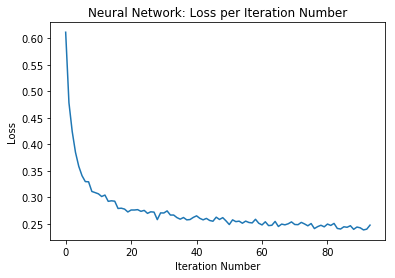

In [197]:
plt.plot(res[1])
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.title("Neural Network: Loss per Iteration Number")
plt.show()

In [198]:
test_res = test_DNN(data=X_test, target=y_test, model=res[0], batch_size=200)

Testing accuracy of the given model is 0.916.


In [199]:
# Save the model:
current_working_directory = os.getcwd()
torch.save(res[0].state_dict(), current_working_directory + '\\Deep_Neural_Network.pth')